In [1]:
import math
import xarray as xr
import cartopy.crs as crs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import numpy as np
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import datetime as dt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from netCDF4 import date2num,num2date
import wrf
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords
from wrf import getvar, xy, interp2dxy
from wrf import to_np, getvar, CoordPair, vertcross
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)

In [2]:
#CURRENT DATA
cur_wrfout6 = Dataset('CUR_wrfout_d03_2018-03-25_06_00_00')
cur_wrfout10 = Dataset('CUR_wrfout_d03_2018-03-25_10_00_00')
cur_wrfout11= Dataset('CUR_wrfout_d03_2018-03-25_11_00_00')
cur_wrfout12 = Dataset('CUR_wrfout_d03_2018-03-25_12_00_00')
cur_wrfout13= Dataset('CUR_wrfout_d03_2018-03-25_13_00_00')

#SST DATA
sst_wrfout6 = Dataset('SST_wrfout_d03_2018-03-25_06_00_00')
sst_wrfout10 = Dataset('SST_wrfout_d03_2018-03-25_10_00_00')
sst_wrfout11 = Dataset('SST_wrfout_d03_2018-03-25_11_00_00')
sst_wrfout12 = Dataset('SST_wrfout_d03_2018-03-25_12_00_00')
sst_wrfout13 = Dataset('SST_wrfout_d03_2018-03-25_13_00_00')

In [3]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)
#print(cur_wrfout6.variables)
#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [4]:
#Open HYCOM 25
ds_25 = xr.open_mfdataset('/Users/Anna/Desktop/MSMET/Thesis/WRFprepData/March2018HYCOM/020_archv.2018_084_*_3z.nc')#, combine = 'by_coords', concat_dim = 'time')
ds_25.to_netcdf('test_25.nc')
ds25 = xr.open_dataset('test_25.nc')

#WRFIN_D03
wrfinput_d03 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/wrfinput_d03')

In [5]:
old_d03_SST = wrfinput_d03.SST.values-273.15
old_d03_UOCE = wrfinput_d03.UOCE.values
old_d03_VOCE = wrfinput_d03.VOCE.values
XLAT = wrfinput_d03.XLAT.values
XLON = wrfinput_d03.XLONG.values

print('XLAT: ', XLAT.shape, '\nXLON: ', XLON.shape )
print('Max lat: ', np.max(XLAT), '\Min lat: ', np.min(XLAT))
print('Max lon: ', np.max(XLON), '\Min lon: ', np.min(XLON))
print ('d03_UOCE: ',old_d03_UOCE.shape, '\nd03_VOCE: ',  old_d03_VOCE.shape, '\nd03_SST: ', old_d03_SST.shape)

print('\n\n LAT: ', XLAT)
print('\n\n LON: ', XLON)

#REAL RUN 
latbounds = [24, 29]
lonbounds = [-95, -87]

lats = ds25.Latitude.values[:]
lons = ds25.Longitude.values[:]

#set upper & lower bounds
latli = np.argmin(np.abs(lats-latbounds[0]))
latui = np.argmin(np.abs(lats-latbounds[1]))
lonli = np.argmin(np.abs(lons-lonbounds[0]))
lonui = np.argmin(np.abs(lons-lonbounds[1]))

lat_array=ds25.Latitude.values[latli:latui]
lon_array=ds25.Longitude.values[lonli:lonui]
u_subset_25=ds25.variables['u'][:,0,latli:latui, lonli:lonui]
meanU_25 = u_subset_25.mean('MT')
#meanU_25=meanU_25*0.54 - 0.19
meanU_25=meanU_25*0.75-0.15

#v current
v_subset_25=ds25.variables['v'][:,0,latli:latui, lonli:lonui]
meanV_25 = v_subset_25.mean('MT')
meanV_25=meanV_25*0.27+0.78
#meanV_25=meanV_25

#SST
SST_subset_25=ds25.variables['water_temp'][:,0,latli:latui, lonli:lonui]
meanSST_25 = SST_subset_25.mean('MT')

XLAT:  (1, 474, 639) 
XLON:  (1, 474, 639)
Max lat:  28.640232 \Min lat:  24.351265
Max lon:  -86.96835 \Min lon:  -93.500946
d03_UOCE:  (1, 474, 639) 
d03_VOCE:  (1, 474, 639) 
d03_SST:  (1, 474, 639)


 LAT:  [[[24.351944 24.352158 24.352379 ... 24.351715 24.351501 24.351265]
  [24.360924 24.361137 24.361351 ... 24.360687 24.360466 24.360252]
  [24.369919 24.370125 24.370338 ... 24.369705 24.369476 24.369255]
  ...
  [28.586124 28.586365 28.58659  ... 28.585907 28.585674 28.58545 ]
  [28.595127 28.59534  28.59557  ... 28.594894 28.594662 28.594429]
  [28.604115 28.604328 28.604568 ... 28.603882 28.603653 28.60342 ]]]


 LON:  [[[-93.38281  -93.372955 -93.3631   ... -87.10733  -87.09747  -87.087585]
  [-93.38306  -93.37317  -93.36334  ... -87.107086 -87.09723  -87.08734 ]
  [-93.3833   -93.37341  -93.363556 ... -87.10684  -87.096985 -87.08713 ]
  ...
  [-93.50043  -93.490204 -93.47995  ... -86.98935  -86.979126 -86.96887 ]
  [-93.50067  -93.49045  -93.480225 ... -86.989075 -86.97885  

In [6]:
#March 25 Dopplerscat
ds25_5 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0326-0368_line05.L2.nc')
ds25_6 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0380-0436_line06.L2.nc')
ds25_7 = xr.open_dataset('/Users/Anna/Desktop/MSMET/Thesis/JPL_March22/20180325_084330_0450-0490_line07.L2.nc')


In [7]:
#set other DS variables 
lat25_5=ds25_5.latitude.values
lon25_5=ds25_5.longitude.values
flag25_5=ds25_5.flag.values
u_cur25_5=ds25_5.u_current.values

lat25_6=ds25_6.latitude.values
lon25_6=ds25_6.longitude.values
flag25_6=ds25_6.flag.values
u_cur25_6=ds25_6.u_current.values

lat25_7=ds25_7.latitude.values
lon25_7=ds25_7.longitude.values
flag25_7=ds25_7.flag.values
u_cur25_7=ds25_7.u_current.values

#v current
v_cur25_5=ds25_5.v_current.values
v_cur25_6=ds25_6.v_current.values
v_cur25_7=ds25_7.v_current.values


In [8]:
#Apply Error Flag 
#0 is good, 2 is bad
#set flag to only accept 0
   
lonlen25_5=len(lon25_5)
latlen25_5=len(lat25_5)
goodUarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodUarr25_5[:]=np.nan
goodVarr25_5=np.zeros((latlen25_5,lonlen25_5))
goodVarr25_5[:]=np.nan
for x in range (len(lon25_5)):
    for y in range (len(lat25_5)):
        if flag25_5[y,x] == 0:
            goodUarr25_5[y,x] = u_cur25_5[y,x] 
            goodVarr25_5[y,x] = v_cur25_5[y,x] 
            
lonlen25_6=len(lon25_6)
latlen25_6=len(lat25_6)
goodUarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodUarr25_6[:]=np.nan
goodVarr25_6=np.zeros((latlen25_6,lonlen25_6))
goodVarr25_6[:]=np.nan
for x in range (len(lon25_6)):
    for y in range (len(lat25_6)):
        if flag25_6[y,x] == 0:
            goodUarr25_6[y,x] = u_cur25_6[y,x] 
            goodVarr25_6[y,x] = v_cur25_6[y,x] 
            
lonlen25_7=len(lon25_7)
latlen25_7=len(lat25_7)
goodUarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodUarr25_7[:]=np.nan
goodVarr25_7=np.zeros((latlen25_7,lonlen25_7))
goodVarr25_7[:]=np.nan
for x in range (len(lon25_7)):
    for y in range (len(lat25_7)):
        if flag25_7[y,x] == 0:
            goodUarr25_7[y,x] = u_cur25_7[y,x] 
            goodVarr25_7[y,x] = v_cur25_7[y,x] 


In [9]:
#Gaussian Filter U25
HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)


#make current arrays (u & v) that match lat & lon dimensions, fill with nans 
u25_WRF  = np.zeros((WRF_latLen, WRF_lonLen))   
u25_WRF[:] = -999
DS_weightedU25 = u25_WRF*0
HYCOM_weightedU25 = u25_WRF*0

#at equator, 1deg = 111.31949077920639km, so 1km*(1deg/111.31949077920639km) = 0.00898315
#Great Circle Calculator 
#http://edwilliams.org/gccalc.htm

km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS

for y in range (0, WRF_latLen):  
#for y in range (0, len(WRF_lat)):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
    #for x in range (0, len(WRF_lon)):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_u25HYCOM = 0

        sum_weight_DS25u5 = 0
        sum_product_u25DS5 = 0
        sum_weight_DS25u6 = 0
        sum_product_u25DS6 = 0
        sum_weight_DS25u7 = 0
        sum_product_u25DS7 = 0
       
        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])  

        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25u5_test1_In = np.where(lon25_5 >= min_lon)
        DS25u5_test2_In = np.where(lon25_5 <= max_lon)
        DS25u5_inter_like_lon = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In)
        DS25u5_test1_In = np.where(lat25_5 >= min_lat)
        DS25u5_test2_In = np.where(lat25_5 <= max_lat)
        DS25u5_inter_like_lat = np.intersect1d(DS25u5_test1_In, DS25u5_test2_In) 
        
        DS25u6_test1_In = np.where(lon25_6 >= min_lon)
        DS25u6_test2_In = np.where(lon25_6 <= max_lon)
        DS25u6_inter_like_lon = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In)
        DS25u6_test1_In = np.where(lat25_6 >= min_lat)
        DS25u6_test2_In = np.where(lat25_6 <= max_lat)
        DS25u6_inter_like_lat = np.intersect1d(DS25u6_test1_In, DS25u6_test2_In) 

        DS25u7_test1_In = np.where(lon25_7 >= min_lon)
        DS25u7_test2_In = np.where(lon25_7 <= max_lon)
        DS25u7_inter_like_lon = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)
        DS25u7_test1_In = np.where(lat25_7 >= min_lat)
        DS25u7_test2_In = np.where(lat25_7 <= max_lat)
        DS25u7_inter_like_lat = np.intersect1d(DS25u7_test1_In, DS25u7_test2_In)

        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index     
        DS25u5_lon_indices =  DS25u5_inter_like_lon
        DS25u5_lat_indices =  DS25u5_inter_like_lat
        DS25u6_lon_indices =  DS25u6_inter_like_lon
        DS25u6_lat_indices =  DS25u6_inter_like_lat
        DS25u7_lon_indices =  DS25u7_inter_like_lon
        DS25u7_lat_indices =  DS25u7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25u5_good_lon = lon25_5[DS25u5_lon_indices]
        DS25u5_good_lat = lat25_5[DS25u5_lat_indices] 
        DS25u6_good_lon = lon25_6[DS25u6_lon_indices]
        DS25u6_good_lat = lat25_6[DS25u6_lat_indices] 
        DS25u7_good_lon = lon25_7[DS25u7_lon_indices]
        DS25u7_good_lat = lat25_7[DS25u7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25u5_good_lon_len = len(DS25u5_good_lon)
        DS25u5_good_lat_len = len(DS25u5_good_lat) 
        DS25u6_good_lon_len = len(DS25u6_good_lon)
        DS25u6_good_lat_len = len(DS25u6_good_lat)  
        DS25u7_good_lon_len = len(DS25u7_good_lon)
        DS25u7_good_lat_len = len(DS25u7_good_lat)      
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                #if distance <= 3 * sigma_HYCOM: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    #weight_HYCOM = 0.2*(1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_u25HYCOM = sum_product_u25HYCOM + weight_HYCOM * meanU_25[lat_indices[y_small], lon_indices[x_small]]
                #print('sum product HYCOM', sum_product_u25HYCOM)
                HYCOM_weightedU25[y,x] =  (sum_product_u25HYCOM/sum_weight_HYCOM)
        #print('sum product HYCOM', sum_product_u25HYCOM)
        #loop through values of good DS arrays 
         
        for y_small_DS25u5 in range(0, DS25u5_good_lat_len):
            for x_small_DS25u5 in range(0, DS25u5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u5_good_lat[y_small_DS25u5]-WRF_lat[y])**2+((DS25u5_good_lon[x_small_DS25u5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]): 
                    weight_DS25u5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u5 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u5 = sum_weight_DS25u5 + weight_DS25u5
                    sum_product_u25DS5 = sum_product_u25DS5 + weight_DS25u5 * goodUarr25_5[DS25u5_lat_indices[y_small_DS25u5], DS25u5_lon_indices[x_small_DS25u5]]
                    #print('sum_product_u25DS5: ', sum_product_u25DS5)
                else: 
                    weight_DS25u5 = 0 
                    
        for y_small_DS25u6 in range(0, DS25u6_good_lat_len):
            for x_small_DS25u6 in range(0, DS25u6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25u6_good_lat[y_small_DS25u6]-WRF_lat[y])**2+((DS25u6_good_lon[x_small_DS25u6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]): 
                    weight_DS25u6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u6 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u6 = sum_weight_DS25u6 + weight_DS25u6
                    sum_product_u25DS6 = sum_product_u25DS6 + weight_DS25u6 * goodUarr25_6[DS25u6_lat_indices[y_small_DS25u6], DS25u6_lon_indices[x_small_DS25u6]]
                else: 
                    weight_DS25u6 = 0 
                    
        for y_small_DS25u7 in range(0, DS25u7_good_lat_len):
            for x_small_DS25u7 in range(0, DS25u7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25u7_good_lat[y_small_DS25u7]-WRF_lat[y])**2+((DS25u7_good_lon[x_small_DS25u7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]): 
                    weight_DS25u7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    #weight_DS25u7 = (1 / (np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2))
                    sum_weight_DS25u7 = sum_weight_DS25u7 + weight_DS25u7
                    sum_product_u25DS7 = sum_product_u25DS7 + weight_DS25u7 * goodUarr25_7[DS25u7_lat_indices[y_small_DS25u7], DS25u7_lon_indices[x_small_DS25u7]]
                else: 
                    weight_DS25u7 = 0 
        #print('sum_product_DS: ', sum_product_u25DS5+sum_product_u25DS6+ sum_product_u25DS7)
            
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedU25[y,x] =  (sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/ DS_weight 
        else: 
            DS_weightedU25[y,x] = -999
            
        u25_WRF[y,x] = (sum_product_u25HYCOM + sum_product_u25DS5 + sum_product_u25DS6 + sum_product_u25DS7)/(sum_weight_HYCOM + sum_weight_DS25u5 + sum_weight_DS25u6 + sum_weight_DS25u7) #add each DS sum, add ech sum weigth 


In [10]:
print(u25_WRF.shape) #<---- this the the UOCE for WRF 
print(WRF_lon.shape)
print(WRF_lat.shape)
print(u25_WRF)
print(DS_weightedU25.shape)
print(HYCOM_weightedU25.shape)

for x in u25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in u25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')

(474, 639)
(639,)
(474,)
[[-0.03676818 -0.03676818 -0.03462522 ... -0.39933854 -0.39933854
  -0.39933854]
 [-0.03676818 -0.03574877 -0.03462471 ... -0.40015855 -0.39933854
  -0.39933854]
 [-0.03759319 -0.0365577  -0.03541112 ... -0.39922357 -0.39837169
  -0.39933854]
 ...
 [-0.05680274 -0.05675372 -0.05664098 ... -0.01681774 -0.01658411
  -0.01658411]
 [-0.05700583 -0.05694038 -0.05687633 ... -0.01609657 -0.01579646
  -0.01508605]
 [-0.057189   -0.05710773 -0.05702867 ... -0.01545005 -0.01508605
  -0.01508605]]
(474, 639)
(474, 639)


In [11]:
#Gaussian Filter V25
#HYCOM: lat_array (Y), lon_array (X), meanU_25
#DS: goodUarr25_1-10, lat25_1, lon25_1s

HYCOM_lat = lat_array
HYCOM_lon = lon_array

#REAL RUN 1 
WRF_lat = XLAT[0,:,0]
WRF_lon = XLON[0,0,:]
WRF_latLen = len(WRF_lat)
WRF_lonLen = len(WRF_lon)

v25_WRF = np.zeros((WRF_latLen, WRF_lonLen))  
#u25_WRF[:] = -999
v25_WRF[:] = -999

DS_weightedV25 = v25_WRF*0
HYCOM_weightedV25= v25_WRF*0

#DS sigma??? = 0.03 # 0.015*2   
km_per_deg= 1/0.00898315
sigma_HYCOM = 0.02 #degrees  0.015*2 #For HYCOM 
sigma_HYCOM_km = sigma_HYCOM*km_per_deg
sigma_DS = 1.0 #0.5-1.0 #km 
#sigma_DS_km = sigma_DS*km_per_deg
sigma_DS_km = sigma_DS


for y in range (0, WRF_latLen):  
    #print(' y :', y)
    for x in range (0, WRF_lonLen):
        #print('x:', x)
        sum_weight_HYCOM = 0
        sum_product_v25HYCOM = 0

        sum_weight_DS25v5 = 0
        sum_product_v25DS5 = 0
        sum_weight_DS25v6 = 0
        sum_product_v25DS6 = 0
        sum_weight_DS25v7 = 0
        sum_product_v25DS7 = 0

        #define area of weighting (lat,lon point +- 3 sigma in lat/lon but round up)
        #+- half size 
        #set bounds in lat/lon
        min_lon = max(WRF_lon[x] - 3*sigma_HYCOM, WRF_lon[0])
        max_lon = min(WRF_lon[x] + 3*sigma_HYCOM, WRF_lon[WRF_lonLen -1])
        min_lat = max(WRF_lat[y] - 3*sigma_HYCOM, WRF_lat[0])   
        max_lat = min(WRF_lat[y] + 3*sigma_HYCOM, WRF_lat[WRF_latLen -1])   
        
        good_lon = [] 
        good_lat = []
        inter_like = []
        
        #HYCOM lat/lon comparison 
        test1_In = np.where(HYCOM_lon >= min_lon)
        test2_In = np.where(HYCOM_lon <= max_lon)
        inter_like_lon = np.intersect1d(test1_In, test2_In)
        
        test1_In = np.where(HYCOM_lat >= min_lat)
        test2_In = np.where(HYCOM_lat <= max_lat)
        inter_like_lat = np.intersect1d(test1_In, test2_In)   
        
        #DS lat/lon comparison

        DS25v5_test1_In = np.where(lon25_5 >= min_lon)
        DS25v5_test2_In = np.where(lon25_5 <= max_lon)
        DS25v5_inter_like_lon = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In)
        DS25v5_test1_In = np.where(lat25_5 >= min_lat)
        DS25v5_test2_In = np.where(lat25_5 <= max_lat)
        DS25v5_inter_like_lat = np.intersect1d(DS25v5_test1_In, DS25v5_test2_In) 
        
        DS25v6_test1_In = np.where(lon25_6 >= min_lon)
        DS25v6_test2_In = np.where(lon25_6 <= max_lon)
        DS25v6_inter_like_lon = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In)
        DS25v6_test1_In = np.where(lat25_6 >= min_lat)
        DS25v6_test2_In = np.where(lat25_6 <= max_lat)
        DS25v6_inter_like_lat = np.intersect1d(DS25v6_test1_In, DS25v6_test2_In) 

        DS25v7_test1_In = np.where(lon25_7 >= min_lon)
        DS25v7_test2_In = np.where(lon25_7 <= max_lon)
        DS25v7_inter_like_lon = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)
        DS25v7_test1_In = np.where(lat25_7 >= min_lat)
        DS25v7_test2_In = np.where(lat25_7 <= max_lat)
        DS25v7_inter_like_lat = np.intersect1d(DS25v7_test1_In, DS25v7_test2_In)

        #np.where((HYCOM_lon >= min_lon) and (HYCOM_lon <= max_lon), HYCOM_lon)
        #np.where((HYCOM_lat >= min_lat) and (HYCOM_lat <= max_lat))
        
        #HYCOM index
        lon_indices = inter_like_lon
        lat_indices = inter_like_lat
        
        #DS index       
        DS25v5_lon_indices =  DS25v5_inter_like_lon
        DS25v5_lat_indices =  DS25v5_inter_like_lat
        DS25v6_lon_indices =  DS25v6_inter_like_lon
        DS25v6_lat_indices =  DS25v6_inter_like_lat
        DS25v7_lon_indices =  DS25v7_inter_like_lon
        DS25v7_lat_indices =  DS25v7_inter_like_lat
        
        #Good HYCOM index
        good_lon = HYCOM_lon[lon_indices]
        good_lat = HYCOM_lat[lat_indices]    
        
        #Good DS index
        DS25v5_good_lon = lon25_5[DS25v5_lon_indices]
        DS25v5_good_lat = lat25_5[DS25v5_lat_indices] 
        DS25v6_good_lon = lon25_6[DS25v6_lon_indices]
        DS25v6_good_lat = lat25_6[DS25v6_lat_indices] 
        DS25v7_good_lon = lon25_7[DS25v7_lon_indices]
        DS25v7_good_lat = lat25_7[DS25v7_lat_indices] 
    
        #get lengths of good arrays HYCOM 
        good_lon_len = len(good_lon)
        good_lat_len = len(good_lat)
        
        #DS length of food arrays 
        DS25v5_good_lon_len = len(DS25v5_good_lon)
        DS25v5_good_lat_len = len(DS25v5_good_lat) 
        DS25v6_good_lon_len = len(DS25v6_good_lon)
        DS25v6_good_lat_len = len(DS25v6_good_lat)  
        DS25v7_good_lon_len = len(DS25v7_good_lon)
        DS25v7_good_lat_len = len(DS25v7_good_lat)     
        
        #loop through values of good HYCOM arrays 
        for y_small in range(0, good_lat_len):
            for x_small in range(0, good_lon_len):         
                
                #calcualte the distance, 1km  
                #HYCOM distance 
                distance=(km_per_deg)*np.sqrt((good_lat[y_small]-WRF_lat[y])**2+((good_lon[x_small]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                #print('distance: ', distance)
                #print('3sigma', 3*sigma_HYCOM)
                #print(y, x, y_small, x_small, distance, good_lat[y_small], WRF_lat[y], good_lon[x_small], WRF_lon[x])
                
                #determine weights- get an array of poitns of the smaller domain
                if distance <= 3 * sigma_HYCOM_km: 
                    #weight_HYCOM = 0.2*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                    weight_HYCOM = 800*(1 / (sigma_HYCOM_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_HYCOM_km**2))
                else: 
                    weight_HYCOM = 0 
                    
                #sum wieghts for HYCOM u & v
                sum_weight_HYCOM = sum_weight_HYCOM + weight_HYCOM
                #print('sum_weight_HYCOM: ', sum_weight_HYCOM)

                #if sum of weights != 0, sum product of weights* current value for HYCOM                         
                sum_product_v25HYCOM = sum_product_v25HYCOM + weight_HYCOM * meanV_25[lat_indices[y_small], lon_indices[x_small]]
                HYCOM_weightedV25[y,x] =  sum_product_v25HYCOM/sum_weight_HYCOM

        for y_small_DS25v5 in range(0, DS25v5_good_lat_len):
            for x_small_DS25v5 in range(0, DS25v5_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v5_good_lat[y_small_DS25v5]-WRF_lat[y])**2+((DS25v5_good_lon[x_small_DS25v5]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]): 
                    weight_DS25v5 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v5 = sum_weight_DS25v5 + weight_DS25v5
                    sum_product_v25DS5 = sum_product_v25DS5 + weight_DS25v5 * goodVarr25_5[DS25v5_lat_indices[y_small_DS25v5], DS25v5_lon_indices[x_small_DS25v5]]
                else: 
                    weight_DS25v5 = 0 
                    
        for y_small_DS25v6 in range(0, DS25v6_good_lat_len):
            for x_small_DS25v6 in range(0, DS25v6_good_lon_len):          
                distance=(km_per_deg)*np.sqrt((DS25v6_good_lat[y_small_DS25v6]-WRF_lat[y])**2+((DS25v6_good_lon[x_small_DS25v6]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]): 
                    weight_DS25v6 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v6 = sum_weight_DS25v6 + weight_DS25v6
                    sum_product_v25DS6 = sum_product_v25DS6 + weight_DS25v6 * goodVarr25_6[DS25v6_lat_indices[y_small_DS25v6], DS25v6_lon_indices[x_small_DS25v6]]
                else: 
                    weight_DS25v6 = 0 
                    
        for y_small_DS25v7 in range(0, DS25v7_good_lat_len):
            for x_small_DS25v7 in range(0, DS25v7_good_lon_len):         
                distance=(km_per_deg)*np.sqrt((DS25v7_good_lat[y_small_DS25v7]-WRF_lat[y])**2+((DS25v7_good_lon[x_small_DS25v7]-WRF_lon[x])*np.cos(WRF_lat[y]*(np.pi/180.0)))**2)
                if distance <= 3 * sigma_DS_km and not np.isnan(goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]): 
                    weight_DS25v7 = (1 / (sigma_DS_km * np.sqrt(2 * np.pi))) * np.exp(-(distance**2) / (2*sigma_DS_km**2))
                    sum_weight_DS25v7 = sum_weight_DS25v7 + weight_DS25v7
                    sum_product_v25DS7 = sum_product_v25DS7 + weight_DS25v7 * goodVarr25_7[DS25v7_lat_indices[y_small_DS25v7], DS25v7_lon_indices[x_small_DS25v7]]
                else: 
                    weight_DS25v7 = 0 
           
    #outside of loop: sum of products/sum of weights
        DS_weight = (sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth     
        if DS_weight != 0: 
            DS_weightedV25[y,x] =  (sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(DS_weight) #add each DS sum, add ech sum weigth 
        else: 
            DS_weightedV25[y,x] = -999
                     
        v25_WRF[y,x] = (sum_product_v25HYCOM + sum_product_v25DS5 + sum_product_v25DS6 + sum_product_v25DS7)/(sum_weight_HYCOM + sum_weight_DS25v5 + sum_weight_DS25v6 + sum_weight_DS25v7) #add each DS sum, add ech sum weigth 


In [13]:
print(v25_WRF.shape)
print(WRF_lon.shape)
print(WRF_lat.shape)
print(v25_WRF)
print(DS_weightedV25.shape)
print(HYCOM_weightedV25.shape)

for x in v25_WRF: 
    for y in x: 
        if np.isnan(y):
            print('NaN present')
            
for x in v25_WRF: 
    for y in x: 
        if y == -999:
            print('-999 present')  
print('sigma DS:', sigma_DS)
print('sigma HYCOM', sigma_HYCOM)

(474, 639)
(639,)
(474,)
[[0.86421758 0.86421758 0.86442354 ... 0.94721484 0.94721484 0.94721484]
 [0.86421758 0.86431556 0.86442359 ... 0.94785106 0.94721484 0.94721484]
 [0.86413716 0.86423675 0.86434702 ... 0.94774068 0.94711906 0.94721484]
 ...
 [0.80682278 0.80683526 0.80685814 ... 0.86809943 0.86792558 0.86792558]
 [0.80677201 0.80678861 0.80680485 ... 0.86801113 0.86782245 0.86772943]
 [0.80672622 0.80674678 0.80676678 ... 0.86793198 0.86772943 0.86772943]]
(474, 639)
(474, 639)
sigma DS: 1.0
sigma HYCOM 0.02


In [14]:
#Vorticity ----> WRF currents vorticity
Y = WRF_lat #474
X = WRF_lon #613
U =  u25_WRF #474, 613
V =  v25_WRF #474, 613
print('X: ', X.shape)
print('Y: ', Y.shape)
print('U: ', U.shape)
print('V: ', V.shape)

#metpy vort
#Vorticity=curl
dxdy=mpcalc.lat_lon_grid_deltas(longitude=WRF_lon, latitude=WRF_lat, x_dim=- 1, y_dim=- 2, geod=None)
#print(dxdy.shape)
#print(dxdy)

#metpy.calc.vorticity(u, v, *, dx=None, dy=None, x_dim=- 1, y_dim=- 2)  
mp_curl=mpcalc.vorticity(u=u25_WRF*units('m/s'), v=v25_WRF*units('m/s'), dx=dxdy[0], dy=dxdy[1])


X:  (639,)
Y:  (474,)
U:  (474, 639)
V:  (474, 639)


C:\Users\Anna\anaconda3\envs\metpy\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


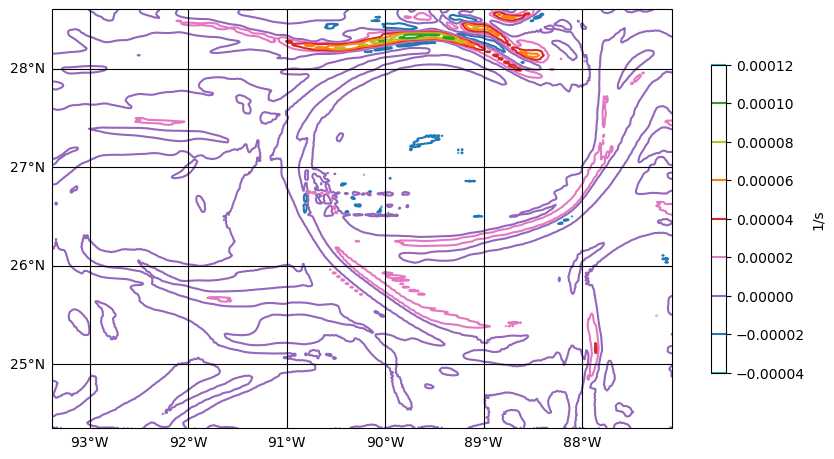

In [15]:
#metpy curl plot 
Y = WRF_lat
X = WRF_lon
U =  u25_WRF
V =  v25_WRF

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

lon2D, lat2D = np.meshgrid(X, Y)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#ax.set_extent([-90.9, -89.65, 26.45, 27.15], crs=mapcrs)
ax.coastlines()

cs = ax.contour(X, Y, mp_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()


In [16]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)

#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [17]:

S_U= []
for y in lat_int_south:
    inner_arr = []
    for x in lon_int_south:
        inner_arr.append(U[y][x])
    S_U.append(inner_arr)
S_U = np.array(S_U)
print('S_U shape: ', S_U.shape)

N_U= []
for y in lat_int_north:
    inner_arr2 = []
    for x in lon_int_north:
        inner_arr2.append(U[y][x])
    N_U.append(inner_arr2)
N_U = np.array(N_U) 
print('N_U shape: ', N_U.shape)

S_V= []
for y in lat_int_south:
    inner_arr3 = []
    for x in lon_int_south:
        inner_arr3.append(V[y][x])
    S_V.append(inner_arr3)
S_V = np.array(S_V)
print('S_V shape: ', S_V.shape)

N_V= []
for y in lat_int_north:
    inner_arr4 = []
    for x in lon_int_north:
        inner_arr4.append(V[y][x])
    N_V.append(inner_arr4)
N_V = np.array(N_V) 
print('N_V shape: ', N_V.shape)

S_U shape:  (67, 118)
N_U shape:  (67, 167)
S_V shape:  (67, 118)
N_V shape:  (67, 167)


In [18]:
X= np.array(north_lon)
Y= np.array(north_lat)
#U=N_U
#V=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X, latitude=Y, x_dim=- 1, y_dim=- 2, geod=None)
 
N_curl=mpcalc.vorticity(u=N_U*units('m/s'), v=N_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(N_curl)

[[6.0438661694226e-06 5.4839157263247395e-06 4.337422843672141e-06 ...  -1.3130351088453426e-05 -1.339964972999028e-05 -1.1906327183874941e-05] [8.456424770323043e-06 8.386938342410362e-06 7.083131685377229e-06 ...  -1.3836817165353485e-05 -1.3349044470078346e-05 -1.2682185872483988e-05] [1.0725978828764857e-05 1.0638568722113202e-05 9.40148647724148e-06 ...  -1.4380345837226188e-05 -1.3526257418534492e-05 -1.2272570620031336e-05] ... [-1.5623052149268982e-05 -1.58956604641503e-05 -1.662372085340354e-05  ... 4.666813239488875e-05 4.670134823793503e-05 4.738935294405608e-05] [-1.5946385329362954e-05 -1.6182185528596394e-05 -1.675986950177598e-05  ... 3.720178226394931e-05 3.661441746119483e-05 3.660824482204263e-05] [-1.4277565148521364e-05 -1.6195794264660352e-05 -1.6150997518188154e-05  ... 2.9776675463971615e-05 3.0107353235049204e-05 2.354627547865876e-05]] / second


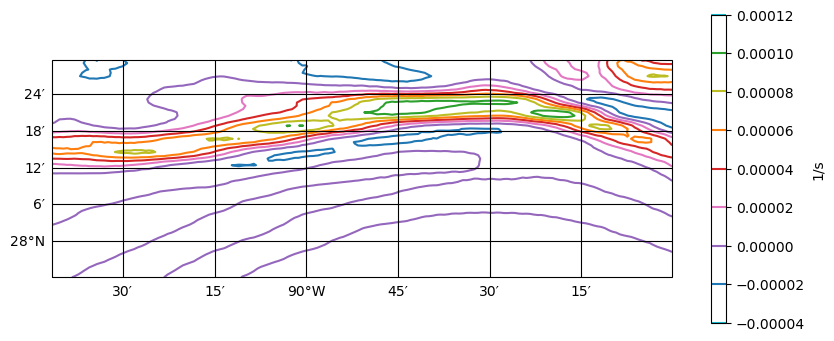

In [19]:

bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]


mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False

plt.show()

In [20]:
X2= np.array(south_lon)
Y2= np.array(south_lat)
#U2=N_U
#V2=N_V

dxdy=mpcalc.lat_lon_grid_deltas(longitude=X2, latitude=Y2, x_dim=- 1, y_dim=- 2, geod=None)
 
S_curl=mpcalc.vorticity(u=S_U*units('m/s'), v=S_V*units('m/s'), dx=dxdy[0], dy=dxdy[1])
print(S_curl)

[[-1.1356667272870751e-05 -1.1242816221363723e-05 -6.928646623509341e-06  ... 9.427031521394439e-06 9.069987097998775e-06 8.754240009654435e-06] [-8.992385778808758e-06 -5.4688753835724965e-06 -6.138354801861083e-07  ... 8.87014676660675e-06 8.863800220135774e-06 8.504148854027193e-06] [-5.154055347921442e-06 -2.2010937545630473e-07 4.8039228708998455e-06  ... 9.034483209232713e-06 8.879974253863667e-06 8.875936729634112e-06] ... [-2.175676583582634e-05 -2.098573306808264e-05 -1.9732313492456827e-05  ... -1.3536393756093026e-05 -1.3200959035693845e-05  -1.3118424623483624e-05] [-2.0243701862002195e-05 -2.0022253933831935e-05 -1.918433741922369e-05  ... -1.2853959646554286e-05 -1.2722557453745495e-05  -1.2266396242174577e-05] [-1.596932362861838e-05 -1.8360756755333996e-05 -1.919440166976694e-05  ... -1.310219571807968e-05 -1.280638306683468e-05 -1.25642136893703e-05]] / second


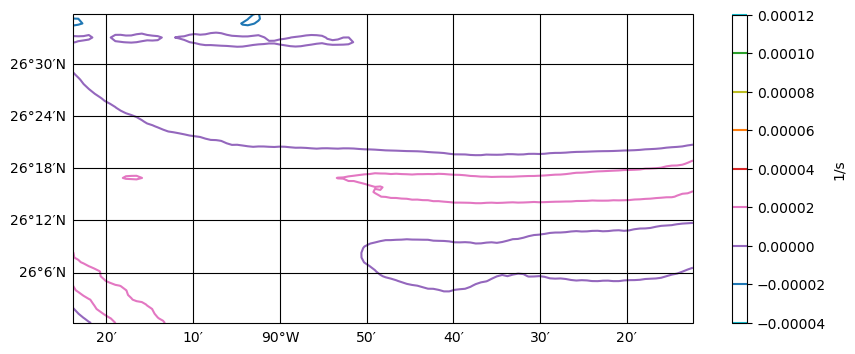

In [21]:
bounds = [-0.00004, -0.00002, 0, 0.00002, 0.00004, 0.00006, 0.00008, 0.00010, 0.00012]

#lon2D, lat2D = np.meshgrid(X2, Y2)
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
ax.coastlines()
cs = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])

CM=ax.get_children()[2]
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
skip = (slice(None, None, 20), slice(None, None, 20))
#plt.quiver(lon2D[skip], lat2D[skip], U[skip], V[skip], color = 'white') #lon, lat, u_curent, v_current
plt.colorbar(cs, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
gl.top_labels = False
gl.ylabels_right = False
#plt.title('Current Speed (Vector in m/s)\n& Curl (Contour in 1/s)')
#save_results_to = '/Users/Anna/Desktop/WRF/'
#plt.savefig(save_results_to + '25_Vectors.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [3]:
#Get PBLH
#Not staggered
cur_pblh_10 = getvar(cur_wrfout10, "PBLH")
cur_pblh_11 = getvar(cur_wrfout11, "PBLH")
cur_pblh_12 = getvar(cur_wrfout12, "PBLH")
cur_pblh_13 = getvar(cur_wrfout13, "PBLH")

sst_pblh_10 = getvar(sst_wrfout10, "PBLH")
sst_pblh_11 = getvar(sst_wrfout11, "PBLH")
sst_pblh_12 = getvar(sst_wrfout12, "PBLH")
sst_pblh_13 = getvar(sst_wrfout13, "PBLH")

cur_U10_10 = getvar(cur_wrfout10, "U10")
cur_U10_11 = getvar(cur_wrfout11, "U10")
cur_U10_12 = getvar(cur_wrfout12, "U10")
cur_U10_13 = getvar(cur_wrfout13, "U10")

sst_U10_10 = getvar(sst_wrfout10, "U10")
sst_U10_11 = getvar(sst_wrfout11, "U10")
sst_U10_12 = getvar(sst_wrfout12, "U10")
sst_U10_13 = getvar(sst_wrfout13, "U10")

cur_V10_10 = getvar(cur_wrfout10, "V10")
cur_V10_11 = getvar(cur_wrfout11, "V10")
cur_V10_12 = getvar(cur_wrfout12, "V10")
cur_V10_13 = getvar(cur_wrfout13, "V10")

sst_V10_10 = getvar(sst_wrfout10, "V10")
sst_V10_11 = getvar(sst_wrfout11, "V10")
sst_V10_12 = getvar(sst_wrfout12, "V10")
sst_V10_13 = getvar(sst_wrfout13, "V10")

#Get U
cur_U_10 = getvar(cur_wrfout10, "U")
cur_U_11 = getvar(cur_wrfout11, "U")
cur_U_12 = getvar(cur_wrfout12, "U")
cur_U_13 = getvar(cur_wrfout13, "U")
#cur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)
#cur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)
#cur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)
#cur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)

sst_U_10 = getvar(sst_wrfout10, "U")
sst_U_11 = getvar(sst_wrfout11, "U")
sst_U_12 = getvar(sst_wrfout12, "U")
sst_U_13 = getvar(sst_wrfout13, "U")
#sst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)
#sst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)
#sst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)
#sst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)

cur_V_10 = getvar(cur_wrfout10, "V")
cur_V_11 = getvar(cur_wrfout11, "V")
cur_V_12 = getvar(cur_wrfout12, "V")
cur_V_13 = getvar(cur_wrfout13, "V")
#cur_V_10 = wrf.destagger(cur_V_10, stagger_dim = 1)
#cur_V_11  = wrf.destagger(cur_V_11, stagger_dim = 1)
#cur_V_12 = wrf.destagger(cur_V_12, stagger_dim = 1)
#cur_V_13  = wrf.destagger(cur_V_13, stagger_dim = 1)

sst_V_10 = getvar(sst_wrfout10, "V")
sst_V_11 = getvar(sst_wrfout11, "V")
sst_V_12 = getvar(sst_wrfout12, "V")
sst_V_13 = getvar(sst_wrfout13, "V")
#sst_V_10 = wrf.destagger(sst_V_10, stagger_dim = 1)
#sst_V_11  = wrf.destagger(sst_V_11, stagger_dim = 1)
#sst_V_12 = wrf.destagger(sst_V_12, stagger_dim = 1)
#sst_V_13  = wrf.destagger(sst_V_13, stagger_dim = 1)

In [25]:
'''
#AVG SFC VORT
cur_U10_N = np.mean( np.array([cur_U10_11, cur_U10_12, cur_U10_13]), axis=0 )
cur_V10_N = np.mean( np.array([cur_V10_11, cur_V10_12, cur_V10_13]), axis=0 )
sst_U10_N = np.mean( np.array([sst_U10_11, sst_U10_12, sst_U10_13]), axis=0 )
sst_V10_N = np.mean( np.array([sst_V10_11, sst_V10_12, sst_V10_13]), axis=0 )

cur_U10_S = np.mean( np.array([cur_U10_10, cur_U10_11, cur_U10_12]), axis=0 )
cur_V10_S = np.mean( np.array([cur_V10_10, cur_V10_11, cur_V10_12]), axis=0 )
sst_U10_S = np.mean( np.array([sst_U10_10, sst_U10_11, sst_U10_12]), axis=0 )
sst_V10_S = np.mean( np.array([sst_V10_10, sst_V10_11, sst_V10_12]), axis=0 )

#surface winds on subdomains
#CUR S U
south_cur_u10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U10_S[y][x])
    south_cur_u10.append(inner_arr_cur)
south_cur_u10 = np.array(south_cur_u10)
print('S', south_cur_u10.shape)

#CUR N U
north_cur_u10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U10_N[y][x])
    north_cur_u10.append(inner_arr_cur)
north_cur_u10 = np.array(north_cur_u10)
print('N', north_cur_u10.shape)

#SST S U
south_sst_u10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U10_S[y][x])
    south_sst_u10.append(inner_arr_sst)
south_sst_u10 = np.array(south_sst_u10)
print('S', south_sst_u10.shape)

#SST N U 
north_sst_u10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U10_N[y][x])
    north_sst_u10.append(inner_arr_sst)
north_sst_u10 = np.array(north_sst_u10)
print('N', north_sst_u10.shape)

#CUR S V
south_cur_v10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V10_S[y][x])
    south_cur_v10.append(inner_arr_cur)
south_cur_v10 = np.array(south_cur_v10)
print('S', south_cur_v10.shape)

#CUR N V
north_cur_v10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V10_N[y][x])
    north_cur_v10.append(inner_arr_cur)
north_cur_v10 = np.array(north_cur_v10)
print('N', north_cur_v10.shape)

#SST S V
south_sst_v10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V10_S[y][x])
    south_sst_v10.append(inner_arr_sst)
south_sst_v10 = np.array(south_sst_v10)
print('S', south_sst_v10.shape)

#SST N V 
north_sst_v10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V10_N[y][x])
    north_sst_v10.append(inner_arr_sst)
north_sst_v10 = np.array(north_sst_v10)
print('N', north_sst_v10.shape)

#surface winds vorticity
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

sst_curl10_N = mpcalc.vorticity(u=north_sst_u10*units('m/s'), v=north_sst_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl10_S = mpcalc.vorticity(u=south_sst_u10*units('m/s'), v=south_sst_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl10_N = mpcalc.vorticity(u=north_cur_u10*units('m/s'), v=north_cur_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl10_S = mpcalc.vorticity(u=south_cur_u10*units('m/s'), v=south_cur_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

N_sfc_diff = cur_curl10_N - sst_curl10_N
S_sfc_diff = cur_curl10_S - sst_curl10_S
'''

S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)


In [23]:
#AVG PBLH VORT 
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#print('agl height shape: ', cur_height_agl13.shape)

#get on PBLH
print(sst_U_10.shape)
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

cur_U_N = np.mean( np.array([cur_uwind11_pblh, cur_uwind12_pblh, cur_uwind13_pblh]), axis=0 )
cur_V_N = np.mean( np.array([cur_vwind11_pblh, cur_vwind12_pblh, cur_vwind13_pblh]), axis=0 )
sst_U_N = np.mean( np.array([sst_uwind11_pblh, sst_uwind12_pblh, sst_uwind13_pblh]), axis=0 )
sst_V_N = np.mean( np.array([sst_vwind11_pblh, sst_vwind12_pblh, sst_vwind13_pblh]), axis=0 )

cur_U_S = np.mean( np.array([cur_uwind10_pblh, cur_uwind11_pblh, cur_uwind12_pblh]), axis=0 )
cur_V_S = np.mean( np.array([cur_vwind10_pblh, cur_vwind11_pblh, cur_vwind12_pblh]), axis=0 )
sst_U_S = np.mean( np.array([sst_uwind10_pblh, sst_uwind11_pblh, sst_uwind12_pblh]), axis=0 )
sst_V_S = np.mean( np.array([sst_vwind10_pblh, sst_vwind11_pblh, sst_vwind12_pblh]), axis=0 )

(99, 474, 639)
(474, 639)


In [24]:
#pblh winds on subdomains
#CUR S U
south_cur_u = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U_S[y][x])
    south_cur_u.append(inner_arr_cur)
south_cur_u = np.array(south_cur_u)
print(south_cur_u.shape)

#CUR N U
north_cur_u = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U_N[y][x])
    north_cur_u.append(inner_arr_cur)
north_cur_u = np.array(north_cur_u)

#SST S U
south_sst_u = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U_S[y][x])
    south_sst_u.append(inner_arr_sst)
south_sst_u = np.array(south_sst_u)

#SST N U 
north_sst_u = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U_N[y][x])
    north_sst_u.append(inner_arr_sst)
north_sst_u = np.array(north_sst_u)
print(north_sst_u.shape)

#CUR S V
south_cur_v = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V_S[y][x])
    south_cur_v.append(inner_arr_cur)
south_cur_v = np.array(south_cur_v)

#CUR N V
north_cur_v = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V_N[y][x])
    north_cur_v.append(inner_arr_cur)
north_cur_v = np.array(north_cur_v)

#SST S V
south_sst_v = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V_S[y][x])
    south_sst_v.append(inner_arr_sst)
south_sst_v = np.array(south_sst_v)

#SST N V 
north_sst_v = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V_N[y][x])
    north_sst_v.append(inner_arr_sst)
north_sst_v = np.array(north_sst_v)
print(north_sst_v.shape)

#calulate  vorticity 
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)


#pblh winds vorticity
sst_curl_N_pblh = mpcalc.vorticity(u=north_sst_u*units('m/s'), v=north_sst_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl_S_pblh = mpcalc.vorticity(u=south_sst_u*units('m/s'), v=south_sst_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl_N_pblh = mpcalc.vorticity(u=north_cur_u*units('m/s'), v=north_cur_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl_S_pblh = mpcalc.vorticity(u=south_cur_u*units('m/s'), v=south_cur_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

      
N_pblh_diff = cur_curl_N_pblh - sst_curl_N_pblh
S_pblh_diff = cur_curl_S_pblh - sst_curl_S_pblh


(67, 118)
(67, 167)
(67, 167)


In [25]:
#geopotential height above ground level
#wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#height_agl6 = wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl13.shape)


cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl13.shape)

agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)


In [26]:
#get on PBLH
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

(474, 639)


In [27]:
#SST reshape U
sst_uwind10_pblh_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_uwind10_pblh[y][x])
    sst_uwind10_pblh_south.append(inner_arr_sst10)
sst_uwind10_pblh_south = np.array(sst_uwind10_pblh_south)

sst_uwind10_pblh_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_uwind10_pblh[y][x])
    sst_uwind10_pblh_north.append(inner_arr_sst10)
sst_uwind10_pblh_north = np.array(sst_uwind10_pblh_north)

sst_uwind11_pblh_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_uwind11_pblh[y][x])
    sst_uwind11_pblh_south.append(inner_arr_sst11)
sst_uwind11_pblh_south = np.array(sst_uwind11_pblh_south)

sst_uwind11_pblh_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_uwind11_pblh[y][x])
    sst_uwind11_pblh_north.append(inner_arr_sst11)
sst_uwind11_pblh_north = np.array(sst_uwind11_pblh_north)

sst_uwind12_pblh_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_uwind12_pblh[y][x])
    sst_uwind12_pblh_south.append(inner_arr_sst12)
sst_uwind12_pblh_south = np.array(sst_uwind12_pblh_south)

sst_uwind12_pblh_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_uwind12_pblh[y][x])
    sst_uwind12_pblh_north.append(inner_arr_sst12)
sst_uwind12_pblh_north = np.array(sst_uwind12_pblh_north)

sst_uwind13_pblh_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_uwind13_pblh[y][x])
    sst_uwind13_pblh_south.append(inner_arr_sst13)
sst_uwind13_pblh_south = np.array(sst_uwind13_pblh_south)

sst_uwind13_pblh_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_uwind13_pblh[y][x])
    sst_uwind13_pblh_north.append(inner_arr_sst13)
sst_uwind13_pblh_north = np.array(sst_uwind13_pblh_north)
print(sst_uwind13_pblh_north.shape)

#SST reshape V
sst_vwind10_pblh_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_vwind10_pblh[y][x])
    sst_vwind10_pblh_south.append(inner_arr_sst10)
sst_vwind10_pblh_south = np.array(sst_vwind10_pblh_south)

sst_vwind10_pblh_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_vwind10_pblh[y][x])
    sst_vwind10_pblh_north.append(inner_arr_sst10)
sst_vwind10_pblh_north = np.array(sst_vwind10_pblh_north)

sst_vwind11_pblh_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_vwind11_pblh[y][x])
    sst_vwind11_pblh_south.append(inner_arr_sst11)
sst_vwind11_pblh_south = np.array(sst_vwind11_pblh_south)

sst_vwind11_pblh_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_vwind11_pblh[y][x])
    sst_vwind11_pblh_north.append(inner_arr_sst11)
sst_vwind11_pblh_north = np.array(sst_vwind11_pblh_north)

sst_vwind12_pblh_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_vwind12_pblh[y][x])
    sst_vwind12_pblh_south.append(inner_arr_sst12)
sst_vwind12_pblh_south = np.array(sst_vwind12_pblh_south)

sst_vwind12_pblh_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_vwind12_pblh[y][x])
    sst_vwind12_pblh_north.append(inner_arr_sst12)
sst_vwind12_pblh_north = np.array(sst_vwind12_pblh_north)

sst_vwind13_pblh_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_vwind13_pblh[y][x])
    sst_vwind13_pblh_south.append(inner_arr_sst13)
sst_vwind13_pblh_south = np.array(sst_vwind13_pblh_south)

sst_vwind13_pblh_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_vwind13_pblh[y][x])
    sst_vwind13_pblh_north.append(inner_arr_sst13)
sst_vwind13_pblh_north = np.array(sst_vwind13_pblh_north)
print(sst_vwind13_pblh_north.shape)

#CUR reshape U
cur_uwind10_pblh_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_uwind10_pblh[y][x])
    cur_uwind10_pblh_south.append(inner_arr_cur10)
cur_uwind10_pblh_south = np.array(cur_uwind10_pblh_south)

cur_uwind10_pblh_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_uwind10_pblh[y][x])
    cur_uwind10_pblh_north.append(inner_arr_cur10)
cur_uwind10_pblh_north = np.array(cur_uwind10_pblh_north)

cur_uwind11_pblh_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_uwind11_pblh[y][x])
    cur_uwind11_pblh_south.append(inner_arr_cur11)
cur_uwind11_pblh_south = np.array(cur_uwind11_pblh_south)

cur_uwind11_pblh_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_uwind11_pblh[y][x])
    cur_uwind11_pblh_north.append(inner_arr_cur11)
cur_uwind11_pblh_north = np.array(cur_uwind11_pblh_north)

cur_uwind12_pblh_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_uwind12_pblh[y][x])
    cur_uwind12_pblh_south.append(inner_arr_cur12)
cur_uwind12_pblh_south = np.array(cur_uwind12_pblh_south)

cur_uwind12_pblh_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_uwind12_pblh[y][x])
    cur_uwind12_pblh_north.append(inner_arr_cur12)
cur_uwind12_pblh_north = np.array(cur_uwind12_pblh_north)

cur_uwind13_pblh_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_uwind13_pblh[y][x])
    cur_uwind13_pblh_south.append(inner_arr_cur13)
cur_uwind13_pblh_south = np.array(cur_uwind13_pblh_south)

cur_uwind13_pblh_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_uwind13_pblh[y][x])
    cur_uwind13_pblh_north.append(inner_arr_cur13)
cur_uwind13_pblh_north = np.array(cur_uwind13_pblh_north)
print(cur_uwind13_pblh_north.shape)

#CUR reshape V
cur_vwind10_pblh_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_vwind10_pblh[y][x])
    cur_vwind10_pblh_south.append(inner_arr_cur10)
cur_vwind10_pblh_south = np.array(cur_vwind10_pblh_south)

cur_vwind10_pblh_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_vwind10_pblh[y][x])
    cur_vwind10_pblh_north.append(inner_arr_cur10)
cur_vwind10_pblh_north = np.array(cur_vwind10_pblh_north)

cur_vwind11_pblh_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_vwind11_pblh[y][x])
    cur_vwind11_pblh_south.append(inner_arr_cur11)
cur_vwind11_pblh_south = np.array(cur_vwind11_pblh_south)

cur_vwind11_pblh_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_vwind11_pblh[y][x])
    cur_vwind11_pblh_north.append(inner_arr_cur11)
cur_vwind11_pblh_north = np.array(cur_vwind11_pblh_north)

cur_vwind12_pblh_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_vwind12_pblh[y][x])
    cur_vwind12_pblh_south.append(inner_arr_cur12)
cur_vwind12_pblh_south = np.array(cur_vwind12_pblh_south)

cur_vwind12_pblh_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_vwind12_pblh[y][x])
    cur_vwind12_pblh_north.append(inner_arr_cur12)
cur_vwind12_pblh_north = np.array(cur_vwind12_pblh_north)

cur_vwind13_pblh_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_vwind13_pblh[y][x])
    cur_vwind13_pblh_south.append(inner_arr_cur13)
cur_vwind13_pblh_south = np.array(cur_vwind13_pblh_south)

cur_vwind13_pblh_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_vwind13_pblh[y][x])
    cur_vwind13_pblh_north.append(inner_arr_cur13)
cur_vwind13_pblh_north = np.array(cur_vwind13_pblh_north)
print(cur_vwind13_pblh_north.shape)

(67, 167)
(67, 167)
(67, 167)
(67, 167)


In [28]:
#calculate speed
sst_north_speed10 = np.sqrt(sst_vwind10_pblh_north**2 + sst_uwind10_pblh_north**2)
sst_south_speed10 = np.sqrt(sst_vwind10_pblh_south**2 + sst_uwind10_pblh_south**2)
cur_north_speed10 = np.sqrt(cur_vwind10_pblh_north**2 + cur_uwind10_pblh_north**2)
cur_south_speed10 = np.sqrt(cur_vwind10_pblh_south**2 + cur_uwind10_pblh_south**2)

sst_north_speed11 = np.sqrt(sst_vwind11_pblh_north**2 + sst_uwind11_pblh_north**2)
sst_south_speed11 = np.sqrt(sst_vwind11_pblh_south**2 + sst_uwind11_pblh_south**2)
cur_north_speed11 = np.sqrt(cur_vwind11_pblh_north**2 + cur_uwind11_pblh_north**2)
cur_south_speed11 = np.sqrt(cur_vwind11_pblh_south**2 + cur_uwind11_pblh_south**2)

sst_north_speed12 = np.sqrt(sst_vwind12_pblh_north**2 + sst_uwind12_pblh_north**2)
sst_south_speed12 = np.sqrt(sst_vwind12_pblh_south**2 + sst_uwind12_pblh_south**2)
cur_north_speed12 = np.sqrt(cur_vwind12_pblh_north**2 + cur_uwind12_pblh_north**2)
cur_south_speed12 = np.sqrt(cur_vwind12_pblh_south**2 + cur_uwind12_pblh_south**2)

sst_north_speed13 = np.sqrt(sst_vwind13_pblh_north**2 + sst_uwind13_pblh_north**2)
sst_south_speed13 = np.sqrt(sst_vwind13_pblh_south**2 + sst_uwind13_pblh_south**2)
cur_north_speed13 = np.sqrt(cur_vwind13_pblh_north**2 + cur_uwind13_pblh_north**2)
cur_south_speed13 = np.sqrt(cur_vwind13_pblh_south**2 + cur_uwind13_pblh_south**2)

#AVERAGES
sst_north_avg_speed = np.mean( np.array([ sst_north_speed11 , sst_north_speed12, sst_north_speed13 ]), axis=0 )
sst_south_avg_speed = np.mean( np.array([ sst_south_speed10 , sst_south_speed11, sst_south_speed12 ]), axis=0 )
cur_north_avg_speed = np.mean( np.array([ cur_north_speed11 , cur_north_speed12, cur_north_speed13 ]), axis=0 )
cur_south_avg_speed = np.mean( np.array([ cur_south_speed10 , cur_south_speed11, cur_south_speed12 ]), axis=0 )

sst_north_avg_u = np.mean( np.array([sst_uwind11_pblh_north ,sst_uwind12_pblh_north, sst_uwind13_pblh_north]), axis=0 )
sst_south_avg_u = np.mean( np.array([sst_uwind10_pblh_south ,sst_uwind11_pblh_south, sst_uwind12_pblh_south]), axis=0 )
cur_north_avg_u = np.mean( np.array([cur_uwind11_pblh_north ,cur_uwind12_pblh_north, cur_vwind13_pblh_north]), axis=0 )
cur_south_avg_u = np.mean( np.array([cur_uwind10_pblh_south ,cur_uwind11_pblh_south, cur_uwind12_pblh_south]), axis=0 )

sst_north_avg_v = np.mean( np.array([sst_vwind11_pblh_north ,sst_vwind12_pblh_north, sst_uwind13_pblh_north]), axis=0 )
sst_south_avg_v = np.mean( np.array([sst_vwind10_pblh_south ,sst_vwind11_pblh_south, sst_uwind12_pblh_south]), axis=0 )
cur_north_avg_v = np.mean( np.array([cur_vwind11_pblh_north ,cur_vwind12_pblh_north, cur_vwind13_pblh_north]), axis=0 )
cur_south_avg_v = np.mean( np.array([cur_vwind10_pblh_south ,cur_vwind11_pblh_south, cur_uwind12_pblh_south]), axis=0 )

N_u_diff = cur_north_avg_u - sst_north_avg_u
S_u_diff = cur_south_avg_u - sst_south_avg_u 
N_v_diff = cur_north_avg_v - sst_north_avg_v
S_v_diff = cur_south_avg_v - sst_south_avg_v
N_speed_diff = cur_north_avg_speed - sst_north_avg_speed
S_speed_diff = cur_south_avg_speed - sst_south_avg_speed

In [29]:
#calulate  vorticity 
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

#AVERAGES
print(sst_north_avg_u.shape)
print(sst_north_avg_v.shape)
sst_north_avg_vort = mpcalc.vorticity(u=sst_north_avg_u*units('m/s'), v=sst_north_avg_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_south_avg_vort = mpcalc.vorticity(u=sst_south_avg_u*units('m/s'), v=sst_south_avg_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_north_avg_vort = mpcalc.vorticity(u=cur_north_avg_u*units('m/s'), v=cur_north_avg_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_south_avg_vort = mpcalc.vorticity(u=cur_south_avg_u*units('m/s'), v=cur_south_avg_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

#N_pblh_diff = cur_north_avg_vort - sst_north_avg_vort
#S_pblh_diff = cur_south_avg_vort - sst_south_avg_vort

(67, 167)
(67, 167)


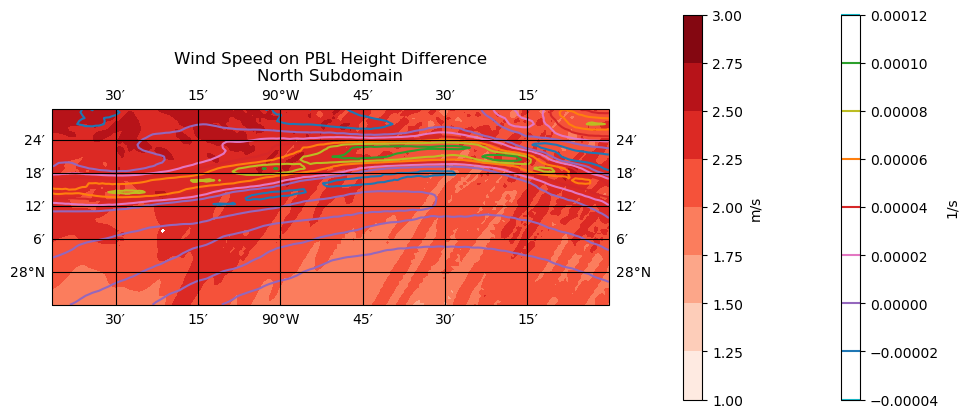

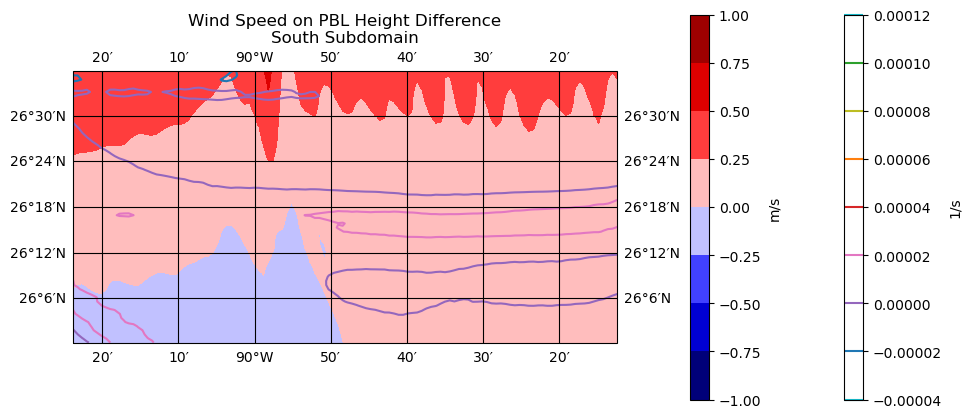

In [30]:
'''
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]

#vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]

#Plots winds with vectors on PBLH

#NORTH CUR
bounds = [6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8, 8.25, 8.5, 9, 9.25, 9.5, 10]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_speed, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_north_avg_u[skip], cur_north_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height\nwith Vectors of Wind on PBL Height\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_speed, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_north_avg_u[skip], sst_north_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height\nwith Vectors of Wind on PBL Height\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH CUR
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_speed, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_south_avg_u[skip], cur_south_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height\nwith Vectors of Wind on PBL Height\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_speed, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_south_avg_u[skip], sst_south_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height\nwith Vectors of Wind on PBL Height\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()
#n_diff = 1 to 3
#s_diff = -1 to 1 

'''
#N DIFF 
diff_bounds = [1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_speed_diff, levels = diff_bounds, cmap ='Reds')
#cs = ax.contourf(north_lon, north_lat, N_pblh_diff)
PCM=ax.get_children()[2]
#xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
#skip = (slice(None, None, 5), slice(None, None, 5))
#plt.quiver(xlon2D[skip], xlat2D[skip], N_u_diff[skip], N_v_diff[skip], color = 'red')
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = diff_bounds, label = 'm/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#S DIFF
diff_bounds = [-1.0, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, S_speed_diff, levels = diff_bounds, cmap ='seismic')
#cs = ax.contourf(south_lon, south_lat, S_pblh_diff)
PCM=ax.get_children()[2]
#xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
#skip = (slice(None, None, 5), slice(None, None, 5))
#plt.quiver(xlon2D[skip], xlat2D[skip], S_u_diff[skip], S_v_diff[skip], color = 'red')
plt.colorbar(cs2, ax=ax, ticks = bounds, shrink = 0.5, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = diff_bounds, label = 'm/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed on PBL Height Difference\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#n_diff = 1 to 3
#s_diff = -1 to 1 


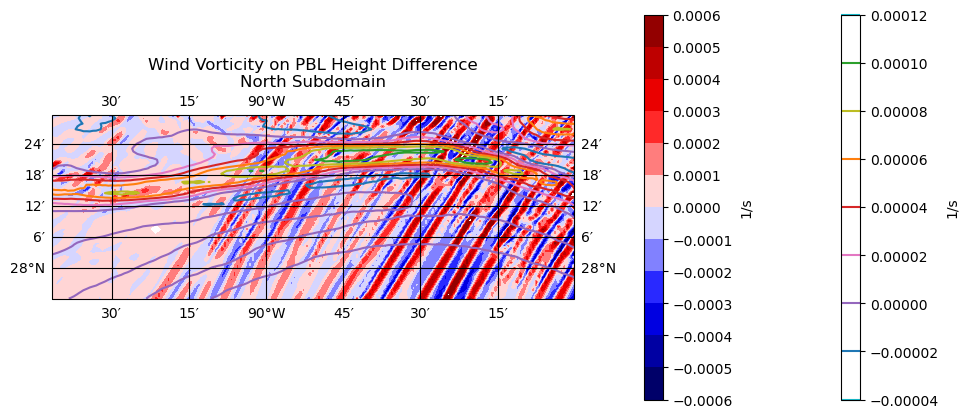

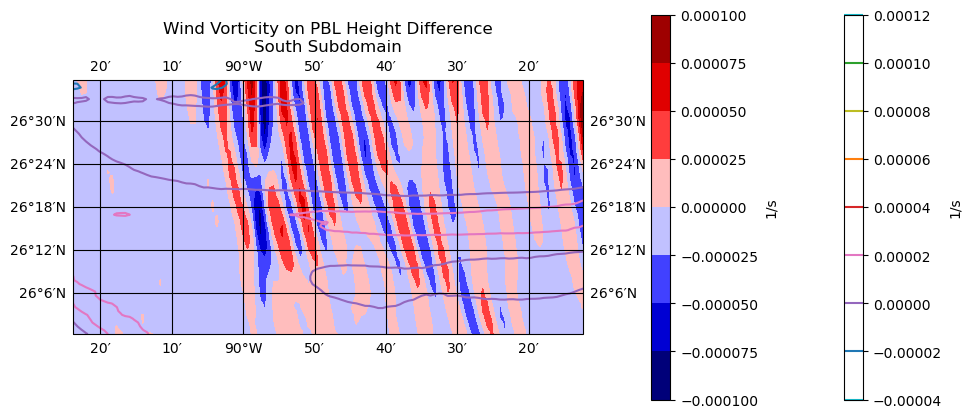

In [35]:
N_vort_diff = cur_north_avg_vort - sst_north_avg_vort
S_vort_diff = cur_south_avg_vort - sst_south_avg_vort
'''
#Plot vorticity contour and vectors on PBLH
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
#vort_bounds_sfc_N = [-0.00016, -0.00008]

vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]
vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]

#NORTH CUR
bounds = [-0.001, -0.00075, -0.0005, -0.00025, 0, 0.00025, 0.0005, 0.00075, 0.001]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_vort, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_north_avg_u[skip], cur_north_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_vort@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#North SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_vort, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_north_avg_u[skip], sst_north_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_vort@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH CUR
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_vort, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_south_avg_u[skip], cur_south_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_vort@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#South SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_vort, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_south_avg_u[skip], sst_south_avg_v[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_vort@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()
'''
#diff_bounds = [-0.0015, -0.0012, -0.0009, -0.0006, -0.0003, 0, 0.0003, 0.0006, 0.0009, 0.0012, 0.0015]
diff_bounds = [ -0.0006, -0.0005, -0.0004, -0.0003, -0.0002, -0.0001, 0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006 ]
#North Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
cs2 = ax.contour(X, Y, N_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
#SFC VORT
#cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_vort_diff, levels = diff_bounds, cmap ='seismic')
#cs = ax.contourf(north_lon, north_lat, N_vort_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = diff_bounds, label = '1/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_vort@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

diff_bounds = [ -0.0001, -0.000075, -0.00005, -0.000025, 0,0.000025, 0.00005, 0.000075, 0.0001]
#South Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
cs2 = ax.contour(X2, Y2, S_curl, transform=mapcrs, levels = bounds, colors = ['tab:cyan','tab:blue', 'tab:purple', 'tab:pink', 'tab:red', 'tab:orange', 'tab:olive', 'tab:green'])
#SFC VORT
#cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
#ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, S_vort_diff, levels = diff_bounds, cmap ='seismic')
#cs = ax.contourf(south_lon, south_lat, S_vort_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs2, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = diff_bounds, label = '1/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Vorticity on PBL Height Difference\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_vort@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#n_diff = -0.0006 to 0.0006 by 1s 
#s_diff = -3 to 3 by 1s 

In [36]:
#Get on free
#wrfin = Dataset("wrfout_d02_2010-06-13_21:00:00")
#rh = getvar(wrfin, "rh")
#height = getvar(wrfin, "height_agl")
#pblh = getvar(wrfin, "PBLH")
#rh_pblh = interplevel(rh, height, pblh)

sst_uwind10_free = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10+500.0)
sst_uwind11_free = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11+500.0)
sst_uwind12_free = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12+500.0)
sst_uwind13_free = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13+500.0)

cur_uwind10_free = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10+500.0)
cur_uwind11_free = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11+500.0)
cur_uwind12_free = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12+500.0)
cur_uwind13_free = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13+500.0)

sst_vwind10_free = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10+500.0)
sst_vwind11_free = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11+500.0)
sst_vwind12_free = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12+500.0)
sst_vwind13_free = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13+500.0)

cur_vwind10_free = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10+500.0)
cur_vwind11_free = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11+500.0)
cur_vwind12_free = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12+500.0)
cur_vwind13_free = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13+500.0)
print(cur_vwind10_free.shape)



(474, 639)


In [37]:
#reshape free SST U
sst_uwind10_free_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_uwind10_free[y][x])
    sst_uwind10_free_south.append(inner_arr_sst10)
sst_uwind10_free_south = np.array(sst_uwind10_free_south)

sst_uwind10_free_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_uwind10_free[y][x])
    sst_uwind10_free_north.append(inner_arr_sst10)
sst_uwind10_free_north = np.array(sst_uwind10_free_north)

sst_uwind11_free_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_uwind11_free[y][x])
    sst_uwind11_free_south.append(inner_arr_sst11)
sst_uwind11_free_south = np.array(sst_uwind11_free_south)

sst_uwind11_free_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_uwind11_free[y][x])
    sst_uwind11_free_north.append(inner_arr_sst11)
sst_uwind11_free_north = np.array(sst_uwind11_free_north)

sst_uwind12_free_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_uwind12_free[y][x])
    sst_uwind12_free_south.append(inner_arr_sst12)
sst_uwind12_free_south = np.array(sst_uwind12_free_south)

sst_uwind12_free_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_uwind12_free[y][x])
    sst_uwind12_free_north.append(inner_arr_sst12)
sst_uwind12_free_north = np.array(sst_uwind12_free_north)

sst_uwind13_free_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_uwind13_free[y][x])
    sst_uwind13_free_south.append(inner_arr_sst13)
sst_uwind13_free_south = np.array(sst_uwind13_free_south)

sst_uwind13_free_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_uwind13_free[y][x])
    sst_uwind13_free_north.append(inner_arr_sst13)
sst_uwind13_free_north = np.array(sst_uwind13_free_north)

#reshape free SST V
sst_vwind10_free_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_vwind10_free[y][x])
    sst_vwind10_free_south.append(inner_arr_sst10)
sst_vwind10_free_south = np.array(sst_vwind10_free_south)

sst_vwind10_free_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_vwind10_free[y][x])
    sst_vwind10_free_north.append(inner_arr_sst10)
sst_vwind10_free_north = np.array(sst_vwind10_free_north)

sst_vwind11_free_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_vwind11_free[y][x])
    sst_vwind11_free_south.append(inner_arr_sst11)
sst_vwind11_free_south = np.array(sst_vwind11_free_south)

sst_vwind11_free_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_vwind11_free[y][x])
    sst_vwind11_free_north.append(inner_arr_sst11)
sst_vwind11_free_north = np.array(sst_vwind11_free_north)

sst_vwind12_free_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_vwind12_free[y][x])
    sst_vwind12_free_south.append(inner_arr_sst12)
sst_vwind12_free_south = np.array(sst_vwind12_free_south)

sst_vwind12_free_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_vwind12_free[y][x])
    sst_vwind12_free_north.append(inner_arr_sst12)
sst_vwind12_free_north = np.array(sst_vwind12_free_north)

sst_vwind13_free_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_vwind13_free[y][x])
    sst_vwind13_free_south.append(inner_arr_sst13)
sst_vwind13_free_south = np.array(sst_vwind13_free_south)

sst_vwind13_free_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_vwind13_free[y][x])
    sst_vwind13_free_north.append(inner_arr_sst13)
sst_vwind13_free_north = np.array(sst_vwind13_free_north)

#reshape free CUR U
cur_uwind10_free_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_uwind10_free[y][x])
    cur_uwind10_free_south.append(inner_arr_cur10)
cur_uwind10_free_south = np.array(cur_uwind10_free_south)

cur_uwind10_free_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_uwind10_free[y][x])
    cur_uwind10_free_north.append(inner_arr_cur10)
cur_uwind10_free_north = np.array(cur_uwind10_free_north)

cur_uwind11_free_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_uwind11_free[y][x])
    cur_uwind11_free_south.append(inner_arr_cur11)
cur_uwind11_free_south = np.array(cur_uwind11_free_south)

cur_uwind11_free_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_uwind11_free[y][x])
    cur_uwind11_free_north.append(inner_arr_cur11)
cur_uwind11_free_north = np.array(cur_uwind11_free_north)

cur_uwind12_free_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_uwind12_free[y][x])
    cur_uwind12_free_south.append(inner_arr_cur12)
cur_uwind12_free_south = np.array(cur_uwind12_free_south)

cur_uwind12_free_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_uwind12_free[y][x])
    cur_uwind12_free_north.append(inner_arr_cur12)
cur_uwind12_free_north = np.array(cur_uwind12_free_north)

cur_uwind13_free_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_uwind13_free[y][x])
    cur_uwind13_free_south.append(inner_arr_cur13)
cur_uwind13_free_south = np.array(cur_uwind13_free_south)

cur_uwind13_free_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_uwind13_free[y][x])
    cur_uwind13_free_north.append(inner_arr_cur13)
cur_uwind13_free_north = np.array(cur_uwind13_free_north)

#reshape free CUR V 
cur_vwind10_free_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_vwind10_free[y][x])
    cur_vwind10_free_south.append(inner_arr_cur10)
cur_vwind10_free_south = np.array(cur_vwind10_free_south)

cur_vwind10_free_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_vwind10_free[y][x])
    cur_vwind10_free_north.append(inner_arr_cur10)
cur_vwind10_free_north = np.array(cur_vwind10_free_north)

cur_vwind11_free_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_vwind11_free[y][x])
    cur_vwind11_free_south.append(inner_arr_cur11)
cur_vwind11_free_south = np.array(cur_vwind11_free_south)

cur_vwind11_free_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_vwind11_free[y][x])
    cur_vwind11_free_north.append(inner_arr_cur11)
cur_vwind11_free_north = np.array(cur_vwind11_free_north)

cur_vwind12_free_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_vwind12_free[y][x])
    cur_vwind12_free_south.append(inner_arr_cur12)
cur_vwind12_free_south = np.array(cur_vwind12_free_south)

cur_vwind12_free_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_vwind12_free[y][x])
    cur_vwind12_free_north.append(inner_arr_cur12)
cur_vwind12_free_north = np.array(cur_vwind12_free_north)

cur_vwind13_free_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_vwind13_free[y][x])
    cur_vwind13_free_south.append(inner_arr_cur13)
cur_vwind13_free_south = np.array(cur_vwind13_free_south)

cur_vwind13_free_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_vwind13_free[y][x])
    cur_vwind13_free_north.append(inner_arr_cur13)
cur_vwind13_free_north = np.array(cur_vwind13_free_north)


In [38]:
#AVG free U
sst_north_U_free_avg = np.mean( np.array([sst_uwind11_free_north ,sst_uwind12_free_north, sst_uwind13_free_north]), axis=0 )
sst_south_U_free_avg = np.mean( np.array([sst_uwind10_free_south ,sst_uwind11_free_south, sst_uwind12_free_south]), axis=0 )
cur_north_U_free_avg = np.mean( np.array([cur_uwind11_free_north ,cur_uwind12_free_north, cur_uwind13_free_north]), axis=0 )
cur_south_U_free_avg = np.mean( np.array([cur_uwind10_free_south ,cur_uwind11_free_south, cur_uwind12_free_south]), axis=0 )

#AVG free V
sst_north_V_free_avg = np.mean( np.array([sst_vwind11_free_north ,sst_vwind12_free_north, sst_vwind13_free_north]), axis=0 )
sst_south_V_free_avg = np.mean( np.array([sst_vwind10_free_south ,sst_vwind11_free_south, sst_vwind12_free_south]), axis=0 )
cur_north_V_free_avg = np.mean( np.array([cur_vwind11_free_north ,cur_vwind12_free_north, cur_vwind13_free_north]), axis=0 )
cur_south_V_free_avg = np.mean( np.array([cur_vwind10_free_south ,cur_vwind11_free_south, cur_vwind12_free_south]), axis=0 )

#AVG free speed
sst_north_speed_free_avg = np.sqrt(sst_north_U_free_avg**2 + sst_north_V_free_avg**2)
sst_south_speed_free_avg = np.sqrt(sst_south_U_free_avg**2 + sst_south_V_free_avg**2)
cur_north_speed_free_avg = np.sqrt(cur_north_U_free_avg **2 + cur_north_V_free_avg **2)
cur_south_speed_free_avg = np.sqrt(cur_south_U_free_avg**2 + cur_south_V_free_avg**2)

N_free_speed_diff = cur_north_speed_free_avg - sst_north_speed_free_avg 
S_free_speed_diff = cur_south_speed_free_avg - sst_south_speed_free_avg 
N_u_diff = cur_north_V_free_avg - sst_north_V_free_avg
S_u_diff = cur_south_V_free_avg - sst_south_V_free_avg
S_v_diff = cur_south_U_free_avg - sst_south_U_free_avg
N_v_diff = cur_north_U_free_avg - sst_north_U_free_avg

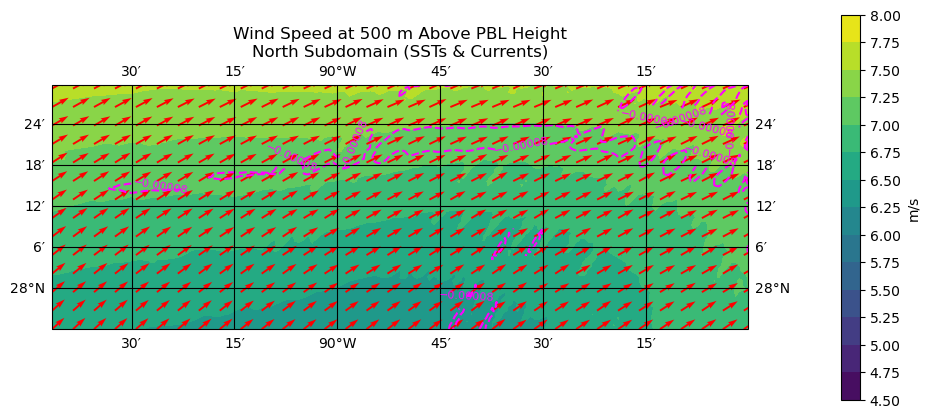

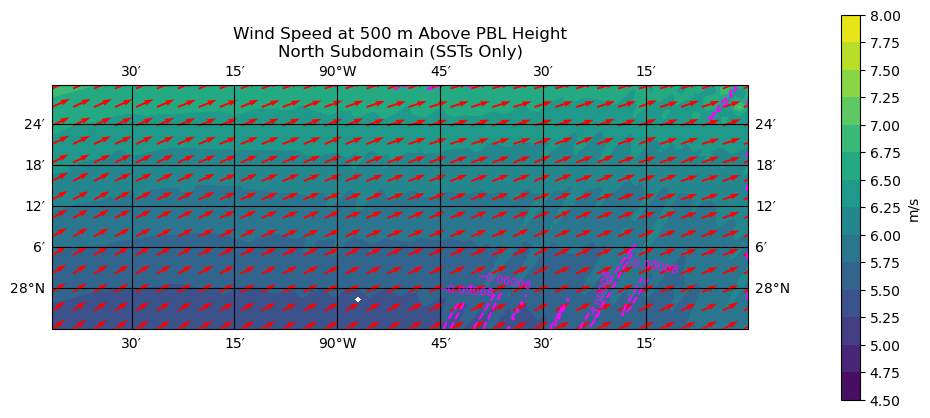

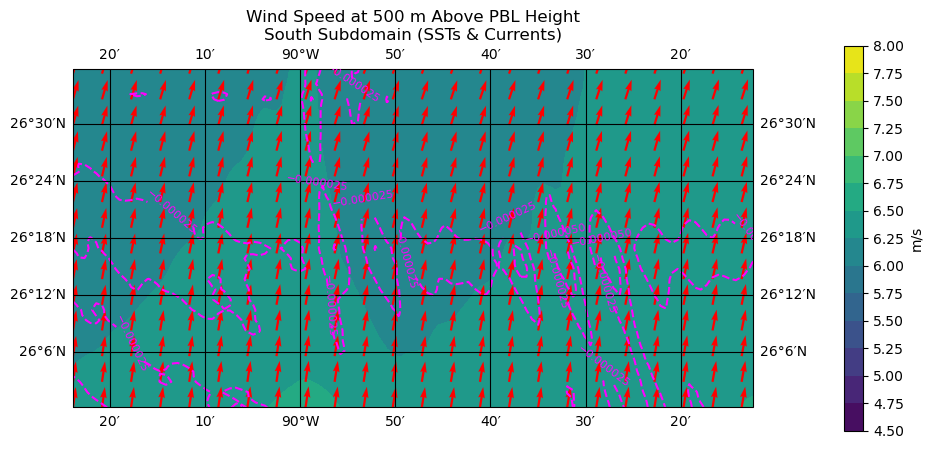

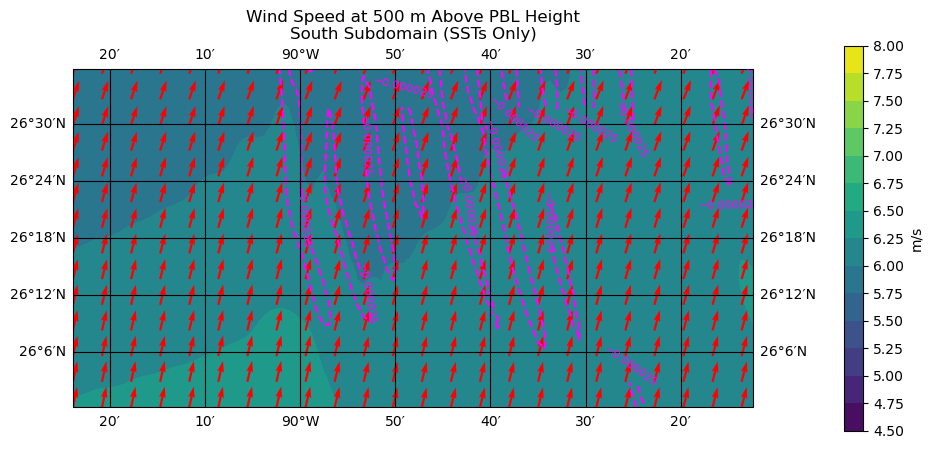

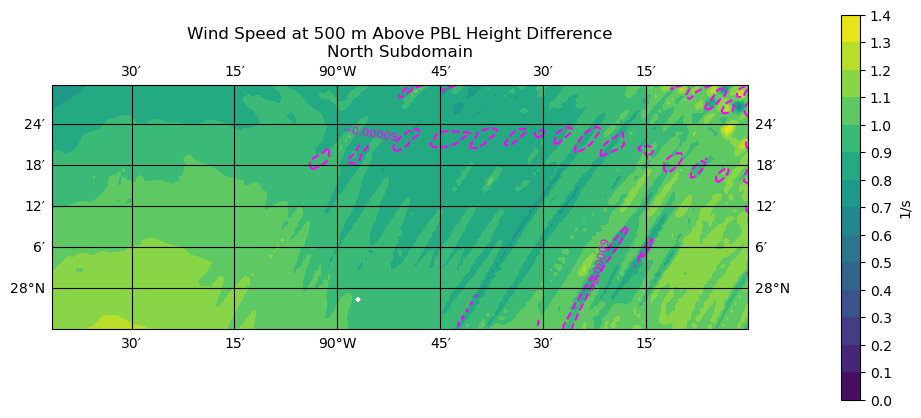

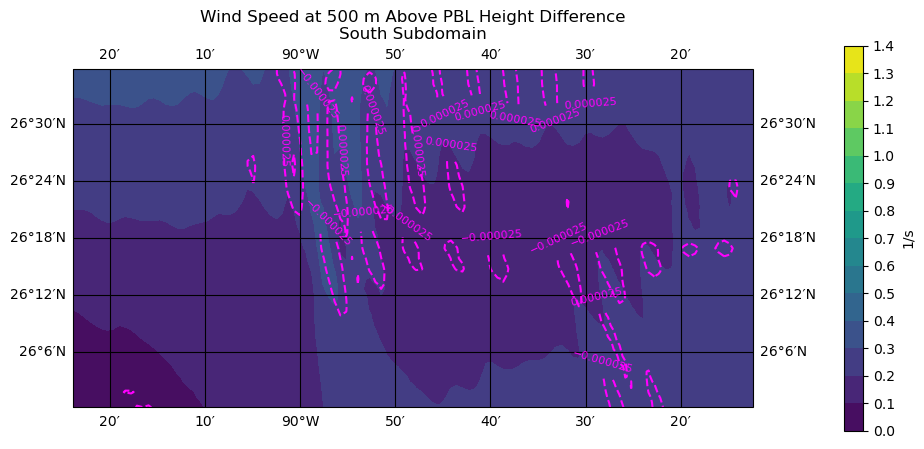

In [28]:
#Plot on free
#vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]
#vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]
vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]

#NORTH CUR
bounds = [4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 6.25, 6.5, 6.75, 7, 7.25, 7.5, 7.75, 8]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_speed_free_avg, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_north_U_free_avg[skip], cur_north_V_free_avg[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#North SST 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_speed_free_avg, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(north_lon, north_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_north_U_free_avg[skip], sst_north_V_free_avg[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH CUR
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_speed_free_avg, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], cur_south_U_free_avg[skip], cur_south_V_free_avg[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#South SST
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_speed_free_avg, levels = bounds)
PCM=ax.get_children()[2]
xlon2D, xlat2D = np.meshgrid(south_lon, south_lat)
skip = (slice(None, None, 5), slice(None, None, 5))
plt.quiver(xlon2D[skip], xlat2D[skip], sst_south_U_free_avg[skip], sst_south_V_free_avg[skip], color = 'red')
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'm/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


bounds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
#North Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_free_speed_diff, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, N_free_speed_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height Difference\nNorth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_winds@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#South Diff
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, S_free_speed_diff, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, S_free_speed_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = '1/s')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = '1/s')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Wind Speed at 500 m Above PBL Height Difference\nSouth Subdomain')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_winds@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

In [4]:
'''
sst_U_avg_north = (sst_U_11 + sst_U_12 + sst_U_13) /3
cur_U_avg_north = (cur_U_11 + cur_U_12 + cur_U_13) /3
sst_V_avg_north = (sst_V_11 + sst_V_12 + sst_V_13) /3
cur_V_avg_north = (cur_V_11 + cur_V_12 + cur_V_13) /3
print(' OLD ')
print('U: ', sst_U_avg_north.shape)
print('U: ', cur_U_avg_north.shape)
print('V: ', sst_V_avg_north.shape)
print('V: ', cur_V_avg_north.shape)
sst_U_avg_south = (sst_U_10 + sst_U_11 + sst_U_12) /3
cur_U_avg_south = (cur_U_10 + cur_U_11 + cur_U_12) /3
sst_V_avg_south = (sst_V_10 + sst_V_11 + sst_V_12) /3
cur_V_avg_south = (cur_V_10 + cur_V_11 + cur_V_12) /3
print('U: ', sst_U_avg_south.shape)
print('U: ', cur_U_avg_south.shape)
print('V: ', sst_V_avg_south.shape)
print('V: ', cur_V_avg_south.shape)

print(' NEW ')
sst_U_avg_north = sst_U_avg_north[:,:,0:639]
cur_U_avg_north = cur_U_avg_north[:,:,0:639]
sst_V_avg_north = sst_V_avg_north[:,0:474,:]
cur_V_avg_north = cur_V_avg_north[:,0:474,:]
print('U: ', sst_U_avg_north.shape)
print('U: ', cur_U_avg_north.shape)
print('V: ', sst_V_avg_north.shape)
print('V: ', cur_V_avg_north.shape)
sst_U_avg_south = sst_U_avg_south[:,:,0:639]
cur_U_avg_south = cur_U_avg_south[:,:,0:639]
sst_V_avg_south = sst_V_avg_south[:,0:474,:]
cur_V_avg_south = cur_V_avg_south[:,0:474,:]


sst_avgSpeed_south = np.sqrt(sst_U_avg_south**2 + sst_V_avg_south**2)
sst_avgSpeed_north = np.sqrt(sst_U_avg_north**2 + sst_V_avg_north**2)
cur_avgSpeed_south = np.sqrt(cur_U_avg_south**2 + cur_V_avg_south**2)
cur_avgSpeed_north = np.sqrt(cur_U_avg_north**2 + cur_V_avg_north**2)
print(sst_avgSpeed_south.shape)
print(sst_avgSpeed_north.shape)
print(cur_avgSpeed_south.shape)
print(cur_avgSpeed_north.shape)

N_speed_diff = cur_avgSpeed_north - sst_avgSpeed_north
S_speed_diff = cur_avgSpeed_south - sst_avgSpeed_south
'''
cur_z10 = getvar(cur_wrfout10, "z")
cur_z11 = getvar(cur_wrfout11, "z")
cur_z12 = getvar(cur_wrfout12, "z")
cur_z13 = getvar(cur_wrfout13, "z")

sst_z10 = getvar(sst_wrfout10, "z")
sst_z11 = getvar(sst_wrfout11, "z")
sst_z12 = getvar(sst_wrfout12, "z")
sst_z13 = getvar(sst_wrfout13, "z")

z_sst_south = (sst_z10 + sst_z11 +sst_z12)/3
z_cur_south = (cur_z10 + cur_z11 +cur_z12)/3
z_sst_north = (sst_z11 + sst_z12 +sst_z13)/3
z_cur_north = (cur_z11 + sst_z12 +sst_z13)/3

print('goal shape: ')
print(z_sst_south .shape)

goal shape: 
(99, 474, 639)


In [5]:
wspd_cur12 =  getvar(cur_wrfout12, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_cur13 =  getvar(cur_wrfout13, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_cur11 =  getvar(cur_wrfout11, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_cur10 =  getvar(cur_wrfout10, "uvmet_wspd_wdir", units='m s-1')[0,:]

N_speed_cur = (wspd_cur11 + wspd_cur12 + wspd_cur13) /3
S_speed_cur = (wspd_cur10 + wspd_cur11 + wspd_cur12) /3

In [6]:
wspd_sst12 =  getvar(sst_wrfout12, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_sst13 =  getvar(sst_wrfout13, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_sst11 =  getvar(sst_wrfout11, "uvmet_wspd_wdir", units='m s-1')[0,:]
wspd_sst10 =  getvar(sst_wrfout10, "uvmet_wspd_wdir", units='m s-1')[0,:]

N_speed_sst = (wspd_sst11 + wspd_sst12 + wspd_sst13) /3
S_speed_sst = (wspd_sst10 + wspd_sst11 + wspd_sst12) /3

N_diff = N_speed_cur - N_speed_sst
S_diff = S_speed_cur - S_speed_sst 

In [37]:
#print(np.max(N_diff)) #2.00637913
#print(np.min(S_diff)) #-2.03316069
#print(np.max(N_diff)) #2.00637913
#print(np.min(S_diff)) #-2.03316069

#print(np.max(N_speed_sst)) #41.03171158
#print(np.min(N_speed_sst)) #0.26709351
#print(np.max(S_speed_sst)) #40.71841049
#print(np.min(S_speed_sst)) #0.42104709

print(np.max(N_speed_cur))
print(np.min(N_speed_cur))
print(np.max(S_speed_cur))
print(np.min(S_speed_cur))
print('  ')
print(N_speed_cur.shape)


<xarray.DataArray 'uvmet_wspd_wdir' ()>
array(41.03628922)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 420.0
    Time       datetime64[ns] 2018-03-25T13:00:00
<xarray.DataArray 'uvmet_wspd_wdir' ()>
array(0.28040722)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 420.0
    Time       datetime64[ns] 2018-03-25T13:00:00
<xarray.DataArray 'uvmet_wspd_wdir' ()>
array(40.72550583)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00
<xarray.DataArray 'uvmet_wspd_wdir' ()>
array(0.42117882)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00
  
(99, 474, 639)


In [7]:
N_cur_pblh = (cur_pblh_11 + cur_pblh_12 +cur_pblh_13) /3
N_sst_pblh = (sst_pblh_11 + sst_pblh_12 +sst_pblh_13) /3
S_cur_pblh = (cur_pblh_10 + cur_pblh_11 +cur_pblh_12) /3
S_sst_pblh = (sst_pblh_10 + sst_pblh_11 +sst_pblh_12) /3

N_pblh_line_sst = wrf.interpline(field2d = N_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.9, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_sst = wrf.interpline(field2d = S_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)
N_pblh_line_cur = wrf.interpline(field2d = N_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.9, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_cur = wrf.interpline(field2d = S_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)


In [24]:
n_N = 11189
n_S = 7906

N_speed_cur_mean =np.nanmean(N_speed_cur[0:20, :, :])
S_speed_cur_mean =np.nanmean(S_speed_cur[0:20, :, :])
N_speed_sst_mean =np.nanmean(N_speed_sst[0:20, :, :])
S_speed_sst_mean =np.nanmean(S_speed_sst[0:20, :, :])
print('N_speed_cur_mean : ', N_speed_cur_mean)
print('S_speed_cur_mean: ', S_speed_cur_mean)
print('N_speed_sst_mean : ', N_speed_sst_mean)
print('S_speed_sst_mean: ', S_speed_sst_mean)
N_speed_cur_std =np.nanstd(N_speed_cur[0:20, :, :])
S_speed_cur_std =np.nanstd(S_speed_cur[0:20, :, :])
N_speed_sst_std =np.nanstd(N_speed_sst[0:20, :, :])
S_speed_sst_std =np.nanstd(S_speed_sst[0:20, :, :])
print(' ' )
print('N_speed_cur_std: ', N_speed_cur_std)
print('S_speed_cur_std: ', S_speed_cur_std)
print('N_speed_sst_std: ', N_speed_sst_std)
print('S_speed_sst_std: ', S_speed_sst_std)
N_diff_speed = N_speed_cur_mean-N_speed_sst_mean
S_diff_speed = S_speed_cur_mean-S_speed_sst_mean
print(' ' )
print('N_diff_speed : ', N_diff_speed )
print('S_diff_speed : ', S_diff_speed )
N_diff_speed_std = N_speed_cur_std-N_speed_sst_std
S_diff_speed_std = S_speed_cur_std-S_speed_sst_std
print(' ' )
print('N_diff_speed_std : ', N_diff_speed_std)
print('S_diff_speed_std : ', S_diff_speed_std )
N_speed_cur_mean_unc =N_speed_cur_std/np.sqrt(n_N)
S_speed_cur_mean_unc=S_speed_cur_std/np.sqrt(n_S)
N_speed_sst_mean_unc=N_speed_sst_std/np.sqrt(n_N)
S_speed_sst_mean_unc=S_speed_sst_std/np.sqrt(n_S)
print(' ' )
print('N_speed_cur_mean_unc: ', N_speed_cur_mean_unc)
print('S_speed_cur_mean_unc: ', S_speed_cur_mean_unc)
print('N_speed_sst_mean_unc: ', N_speed_sst_mean_unc)
print('S_speed_sst_mean_unc: ', S_speed_sst_mean_unc)
N_diff_speed_unc = np.sqrt( ((N_speed_sst_std**2)/n_N) + ((N_speed_cur_std**2)/n_N))
S_diff_speed_unc =  np.sqrt( ((S_speed_sst_std**2)/n_S) + ((S_speed_cur_std**2)/n_S))
print(' ' )
print('N_diff_speed_unc: ', N_diff_speed_unc)
print('S_diff_speed_unc: ', S_diff_speed_unc)

N_speed_cur_mean :  7.0317154
S_speed_cur_mean:  7.4380994
N_speed_sst_mean :  6.9565353
S_speed_sst_mean:  7.3647285
 
N_speed_cur_std:  2.0249991
S_speed_cur_std:  1.9708327
N_speed_sst_std:  1.9814517
S_speed_sst_std:  1.9257795
 
N_diff_speed :  0.07518005
S_diff_speed :  0.07337093
 
N_diff_speed_std :  0.043547392
S_diff_speed_std :  0.045053244
 
N_speed_cur_mean_unc:  0.019143846641387456
S_speed_cur_mean_unc:  0.022165184755868136
N_speed_sst_mean_unc:  0.018732160248618988
S_speed_sst_mean_unc:  0.02165848854249526
 
N_diff_speed_unc:  0.026783963332727725
S_diff_speed_unc:  0.030990087789600853


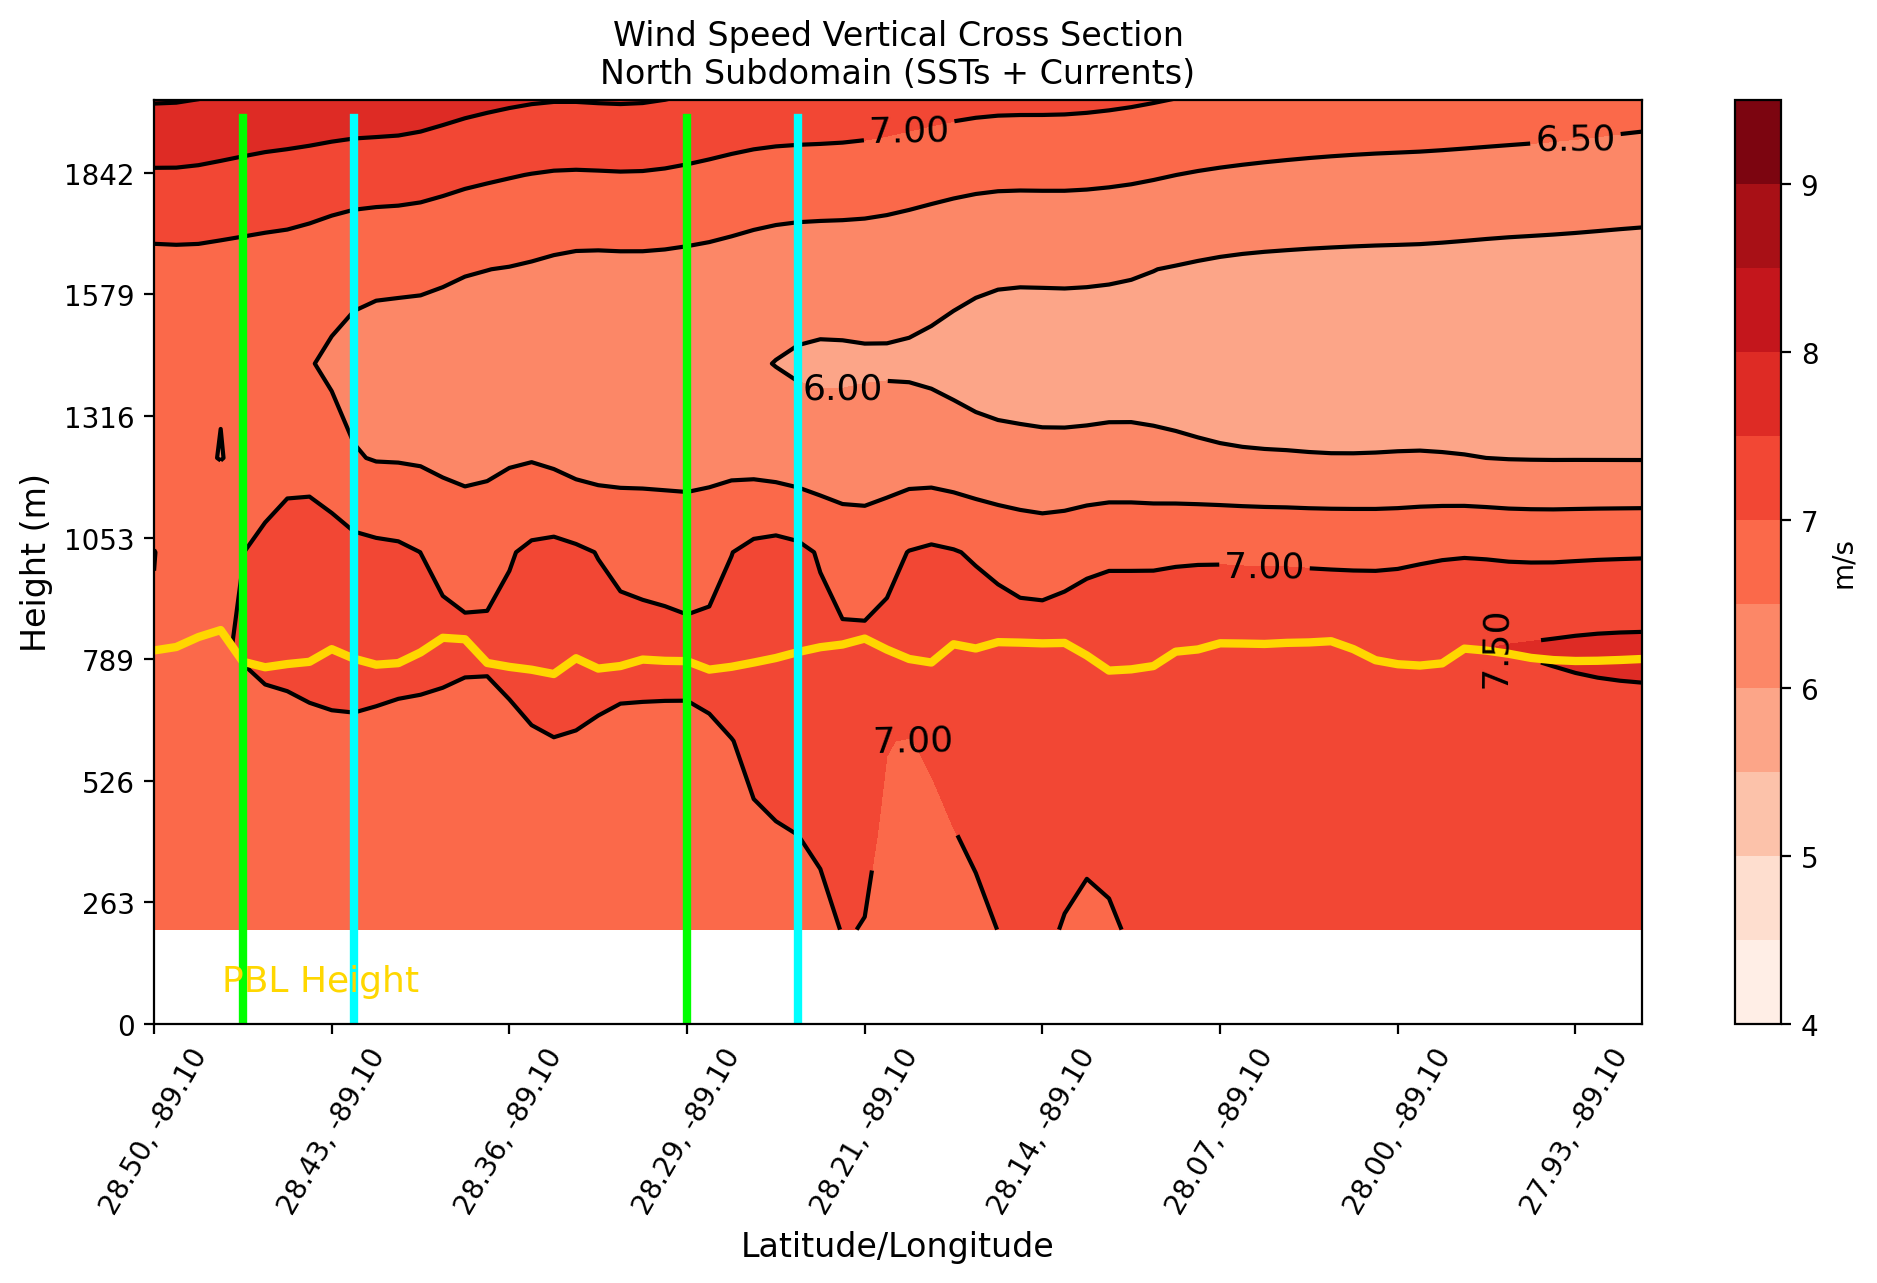

sst_N_mean:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(21.5566, dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 420.0
    Time       datetime64[ns] 2018-03-25T13:00:00
sst_N_std:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(10.92403507)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 420.0
    Time       datetime64[ns] 2018-03-25T13:00:00


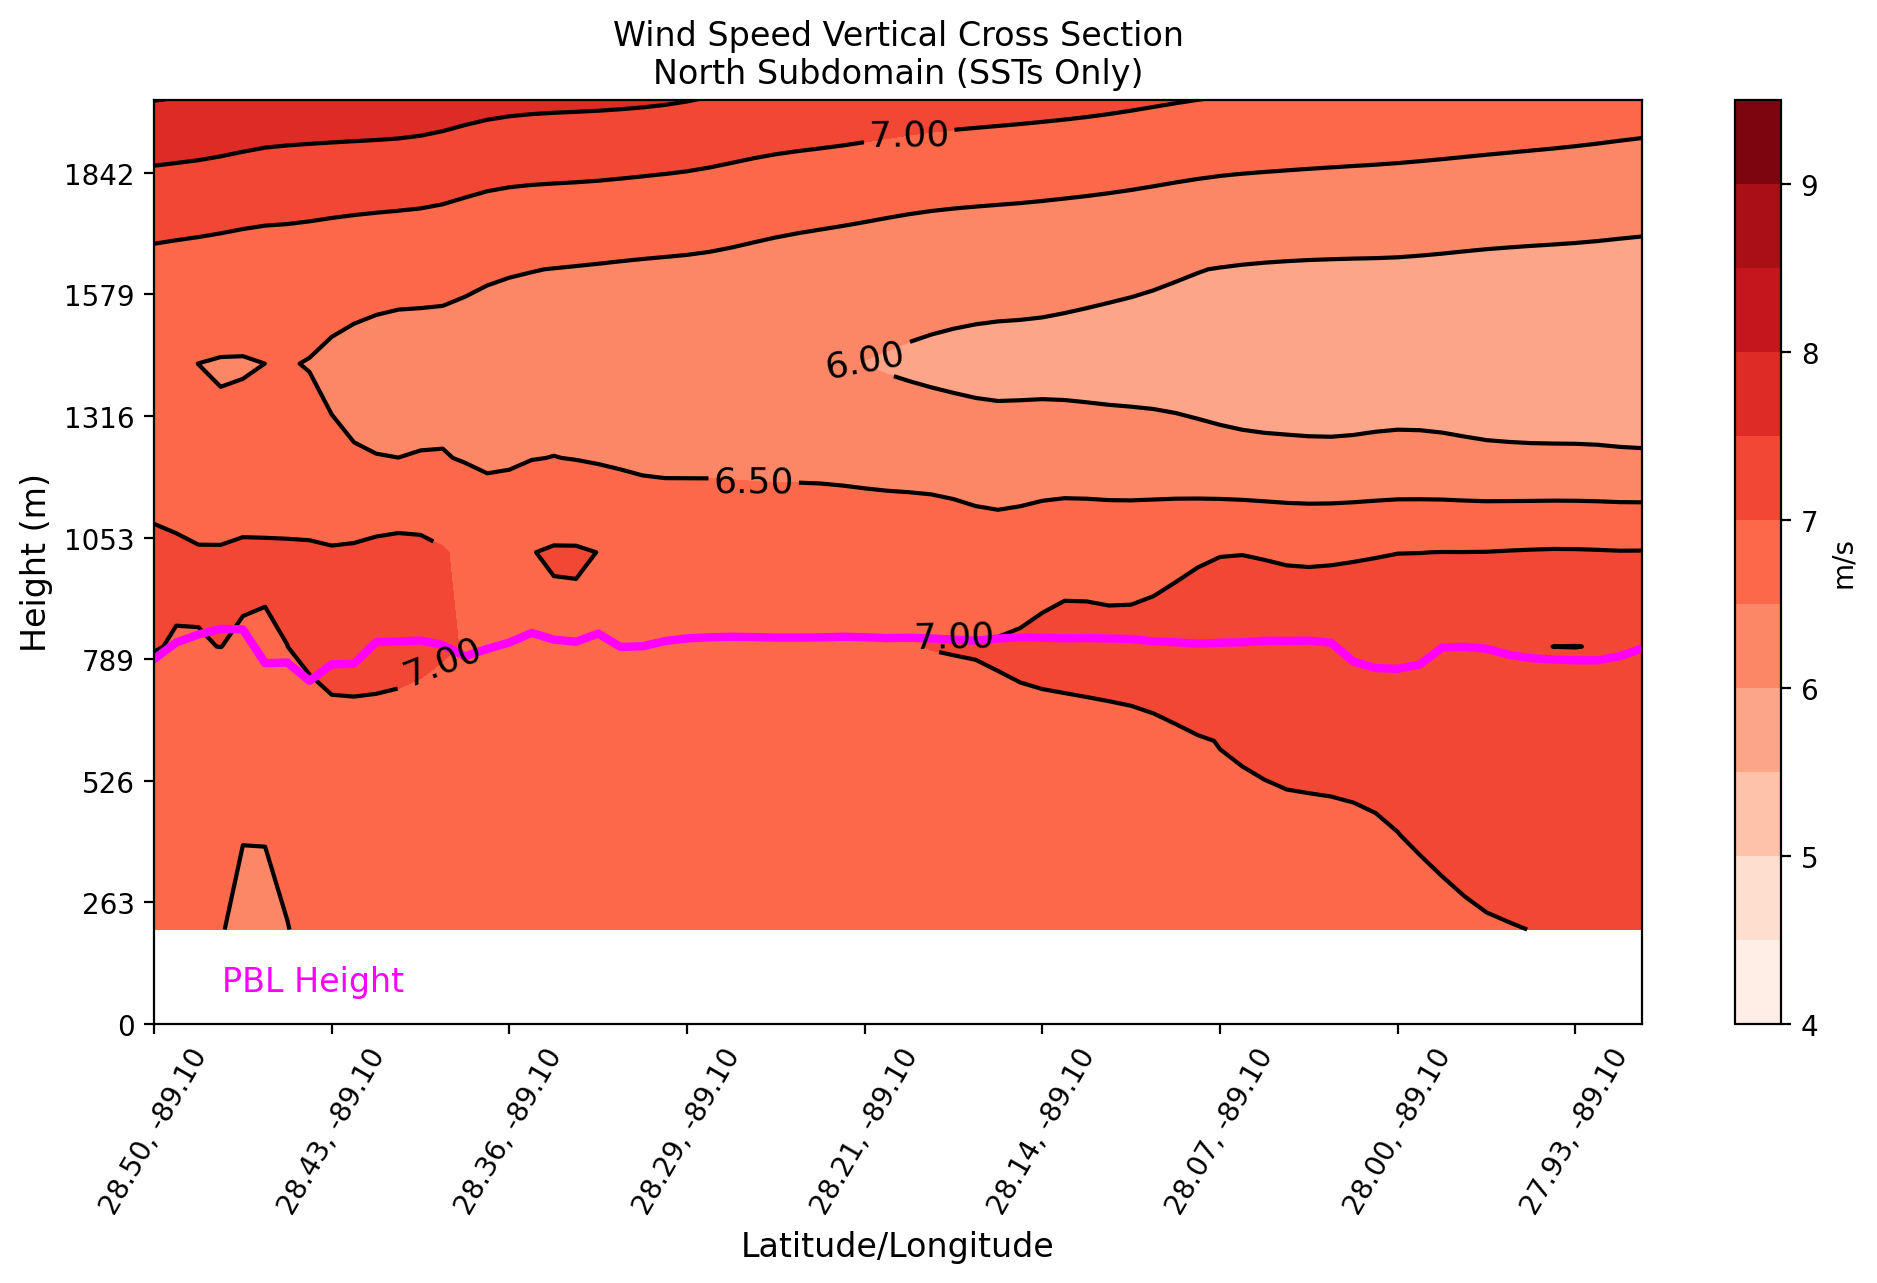

cur_S_mean:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(18.949574, dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00
cur_S_std:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(11.31817722)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00


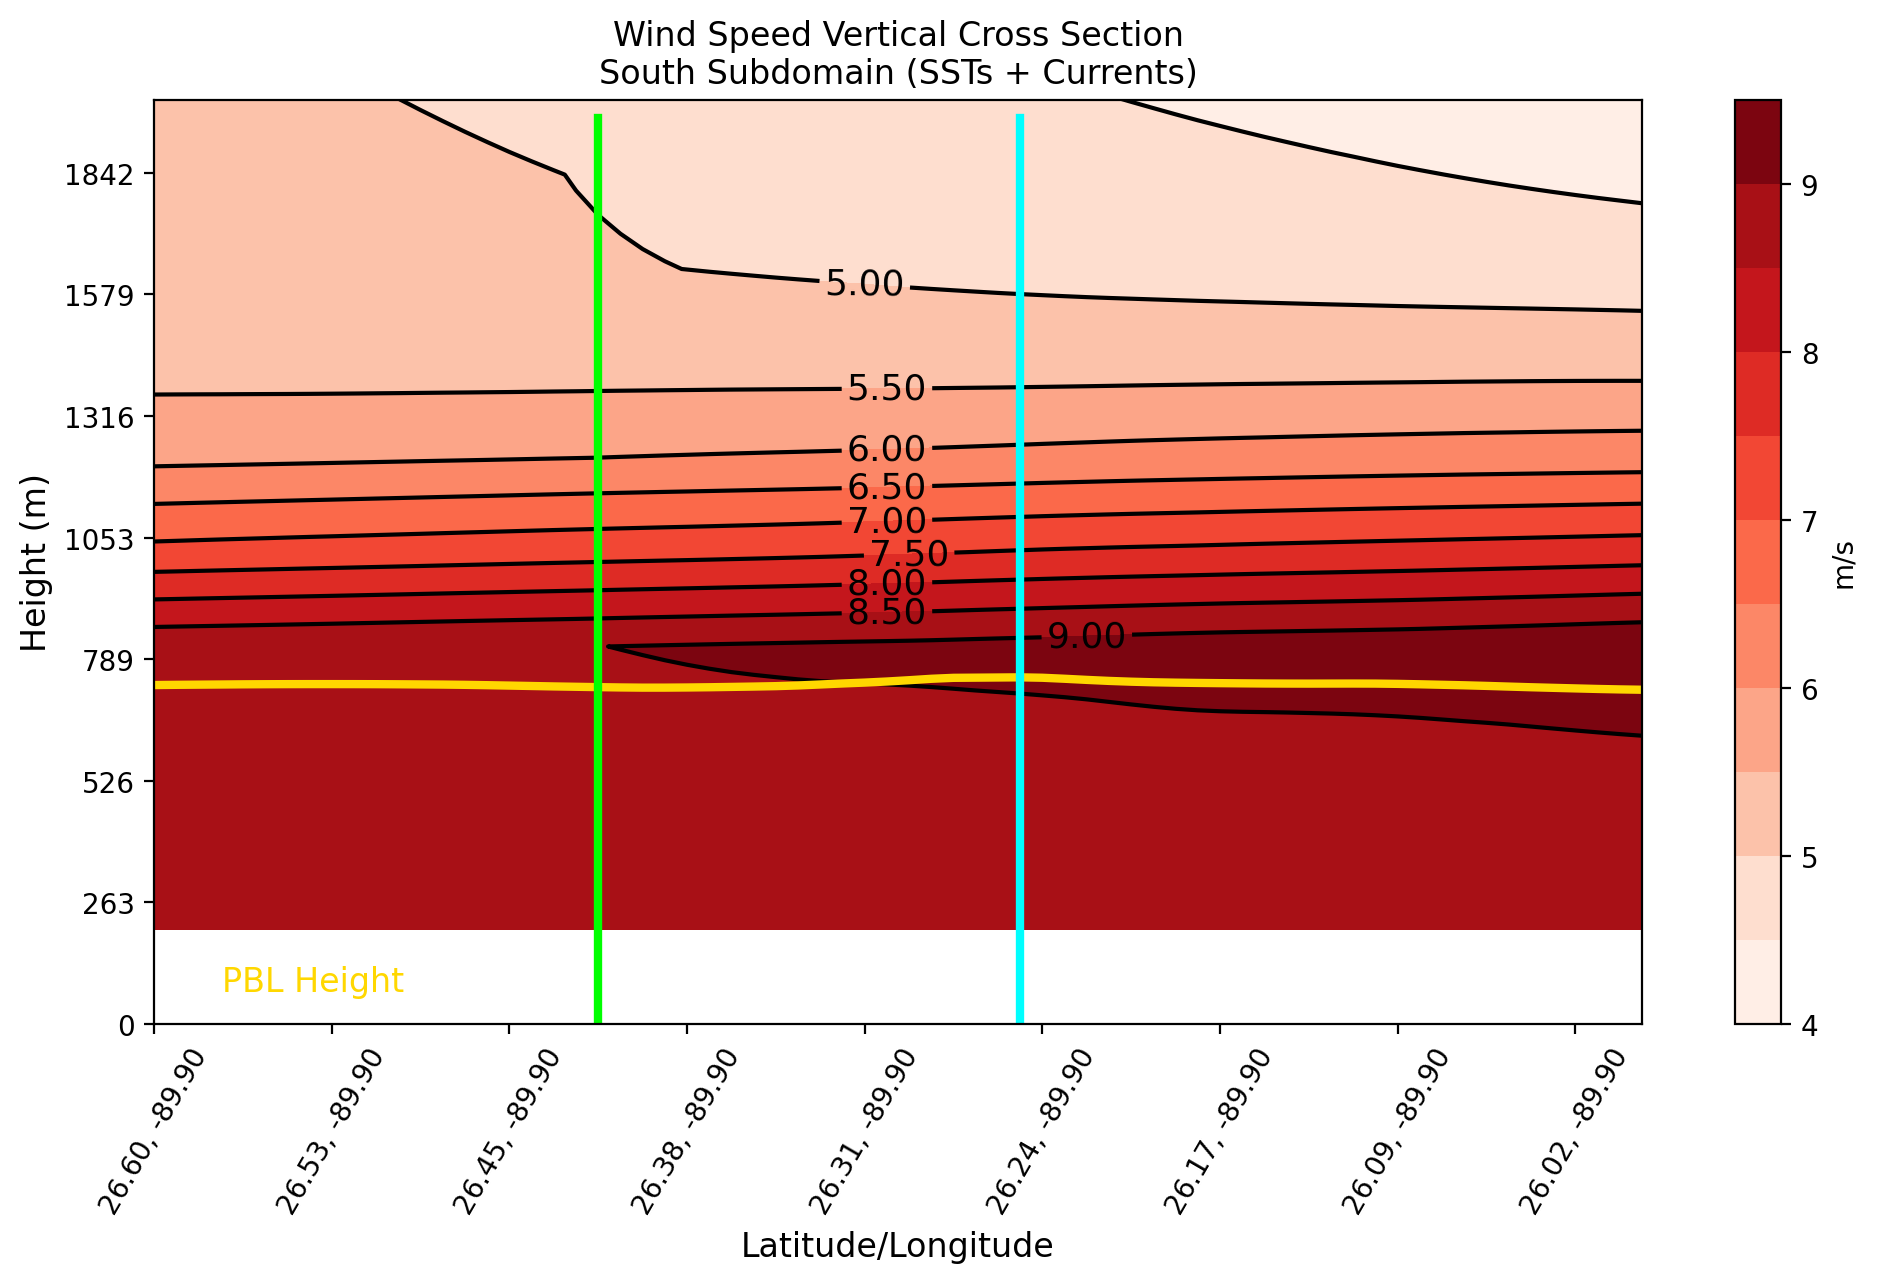

sst_S_mean:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(18.948545, dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00
sst_S_std:  <xarray.DataArray 'uvmet_wspd_wdir_cross' ()>
array(11.31881714)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 360.0
    Time       datetime64[ns] 2018-03-25T12:00:00


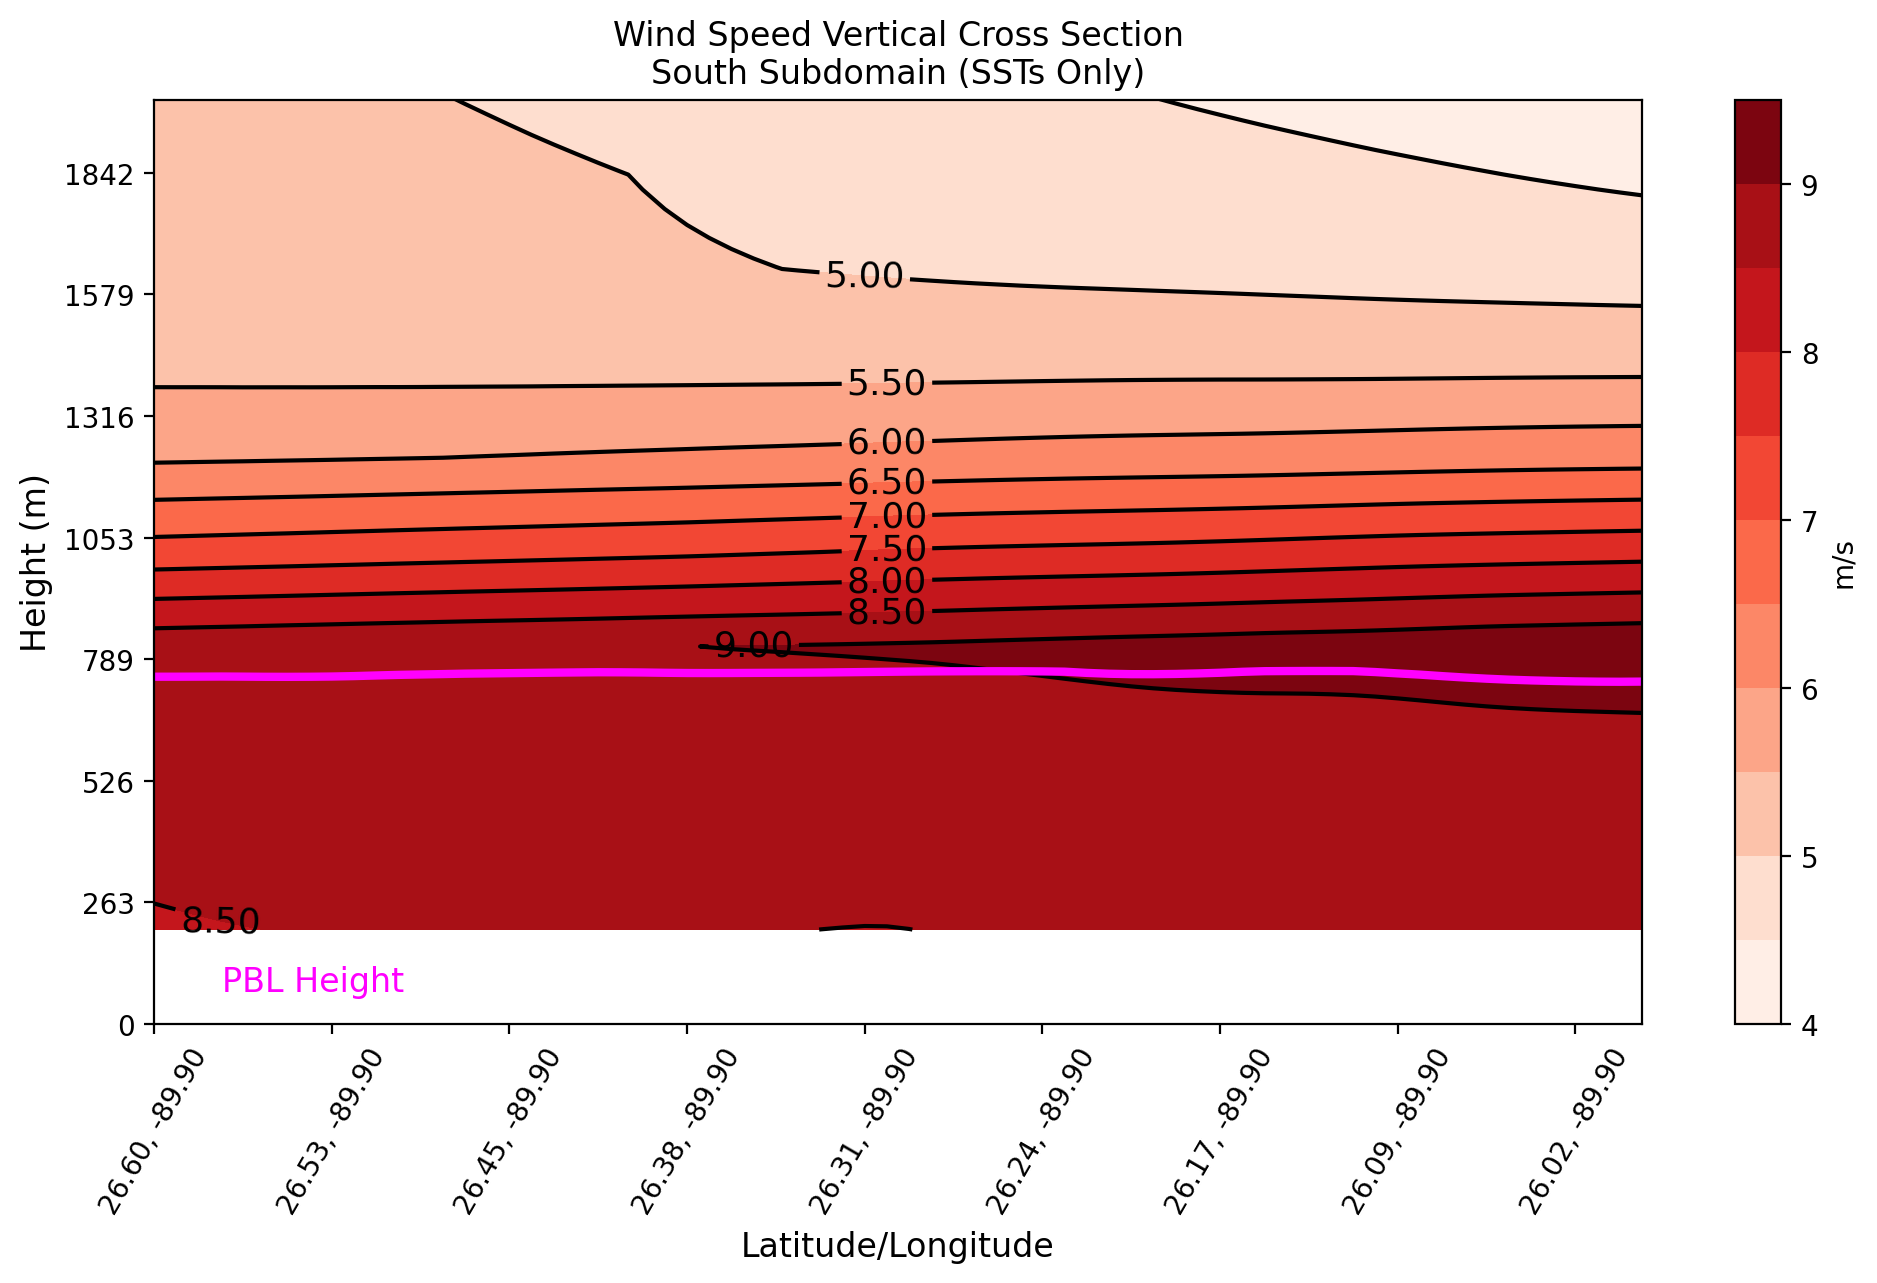

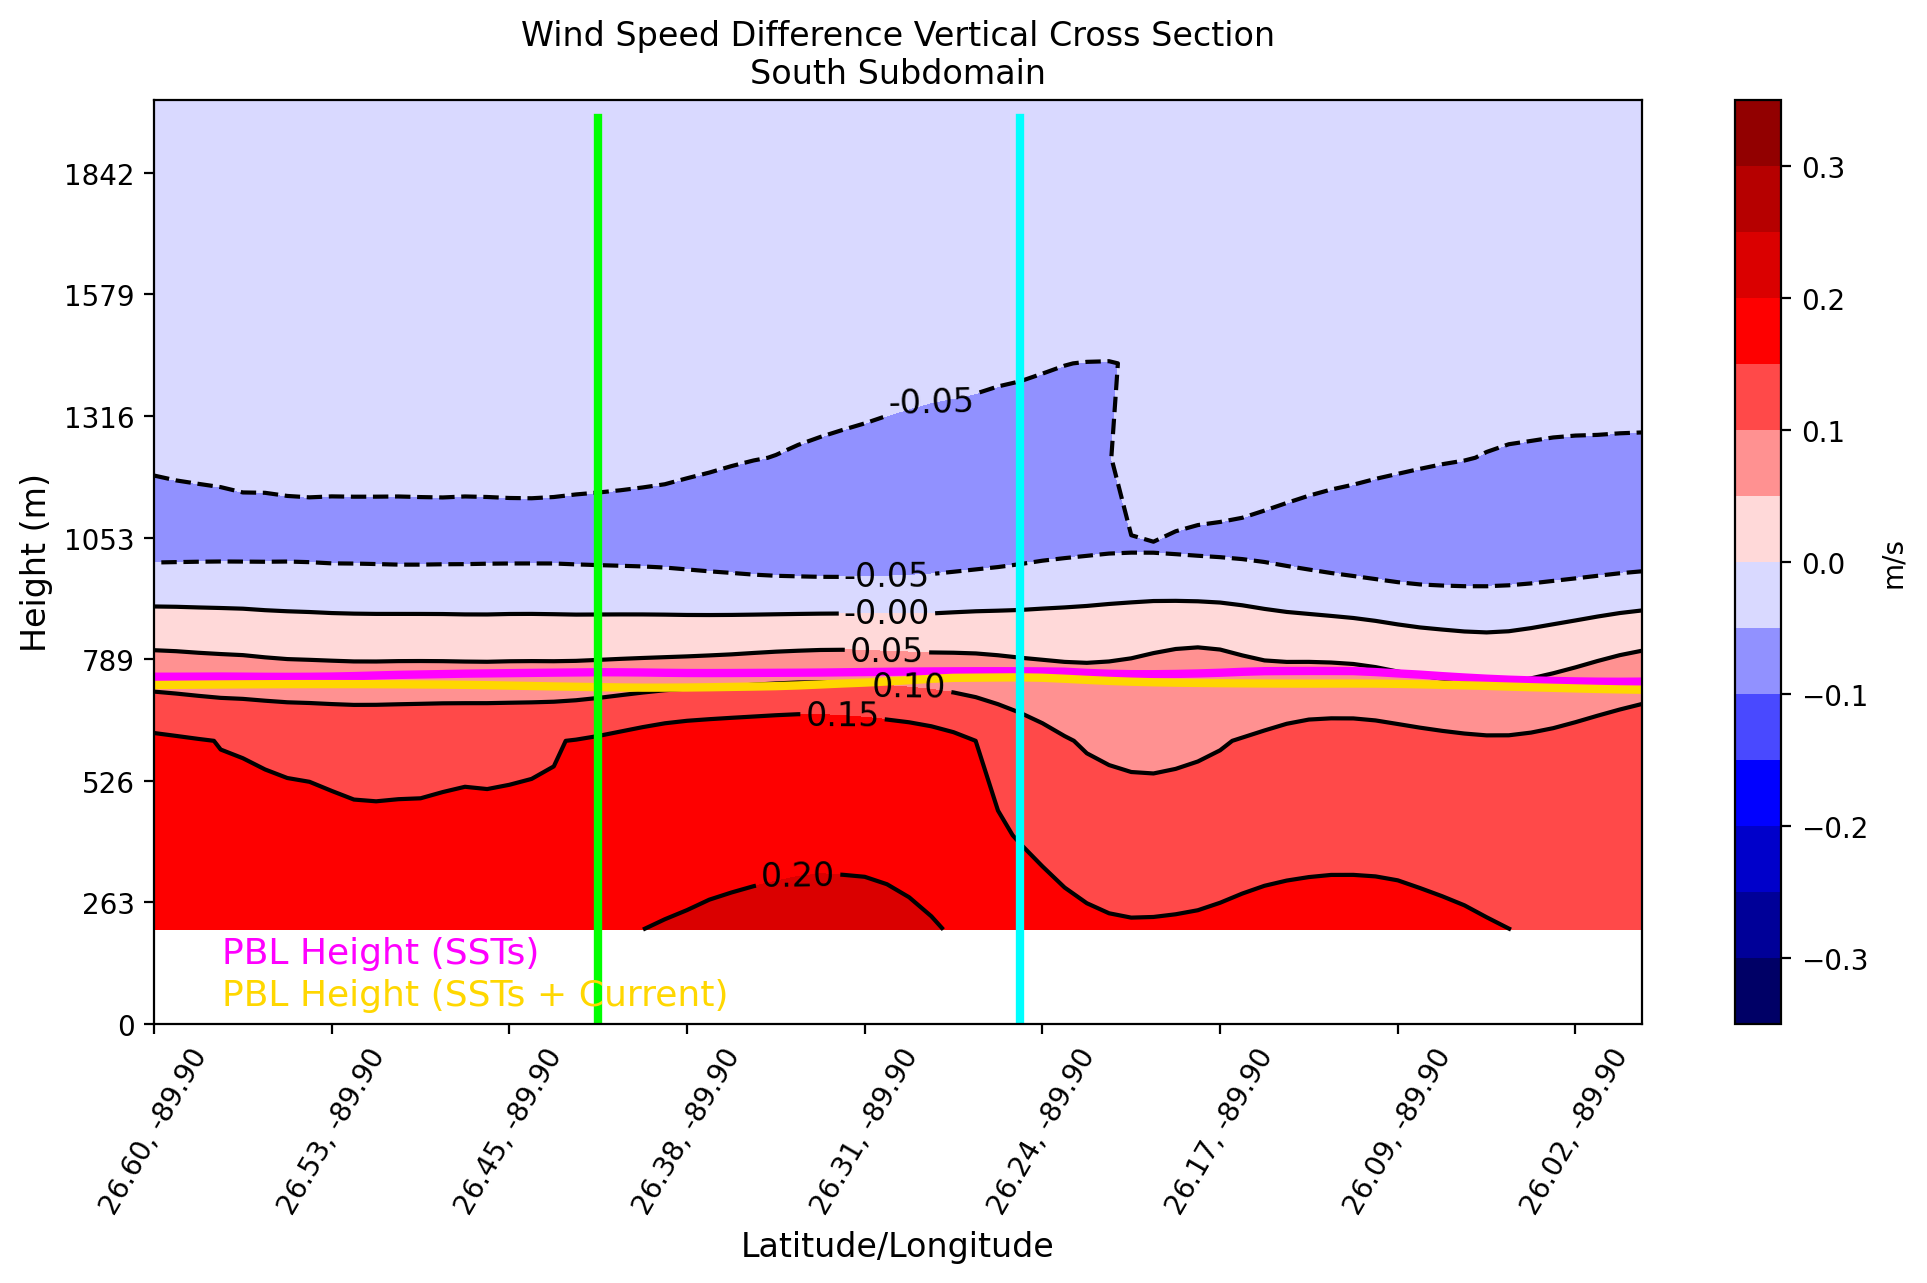

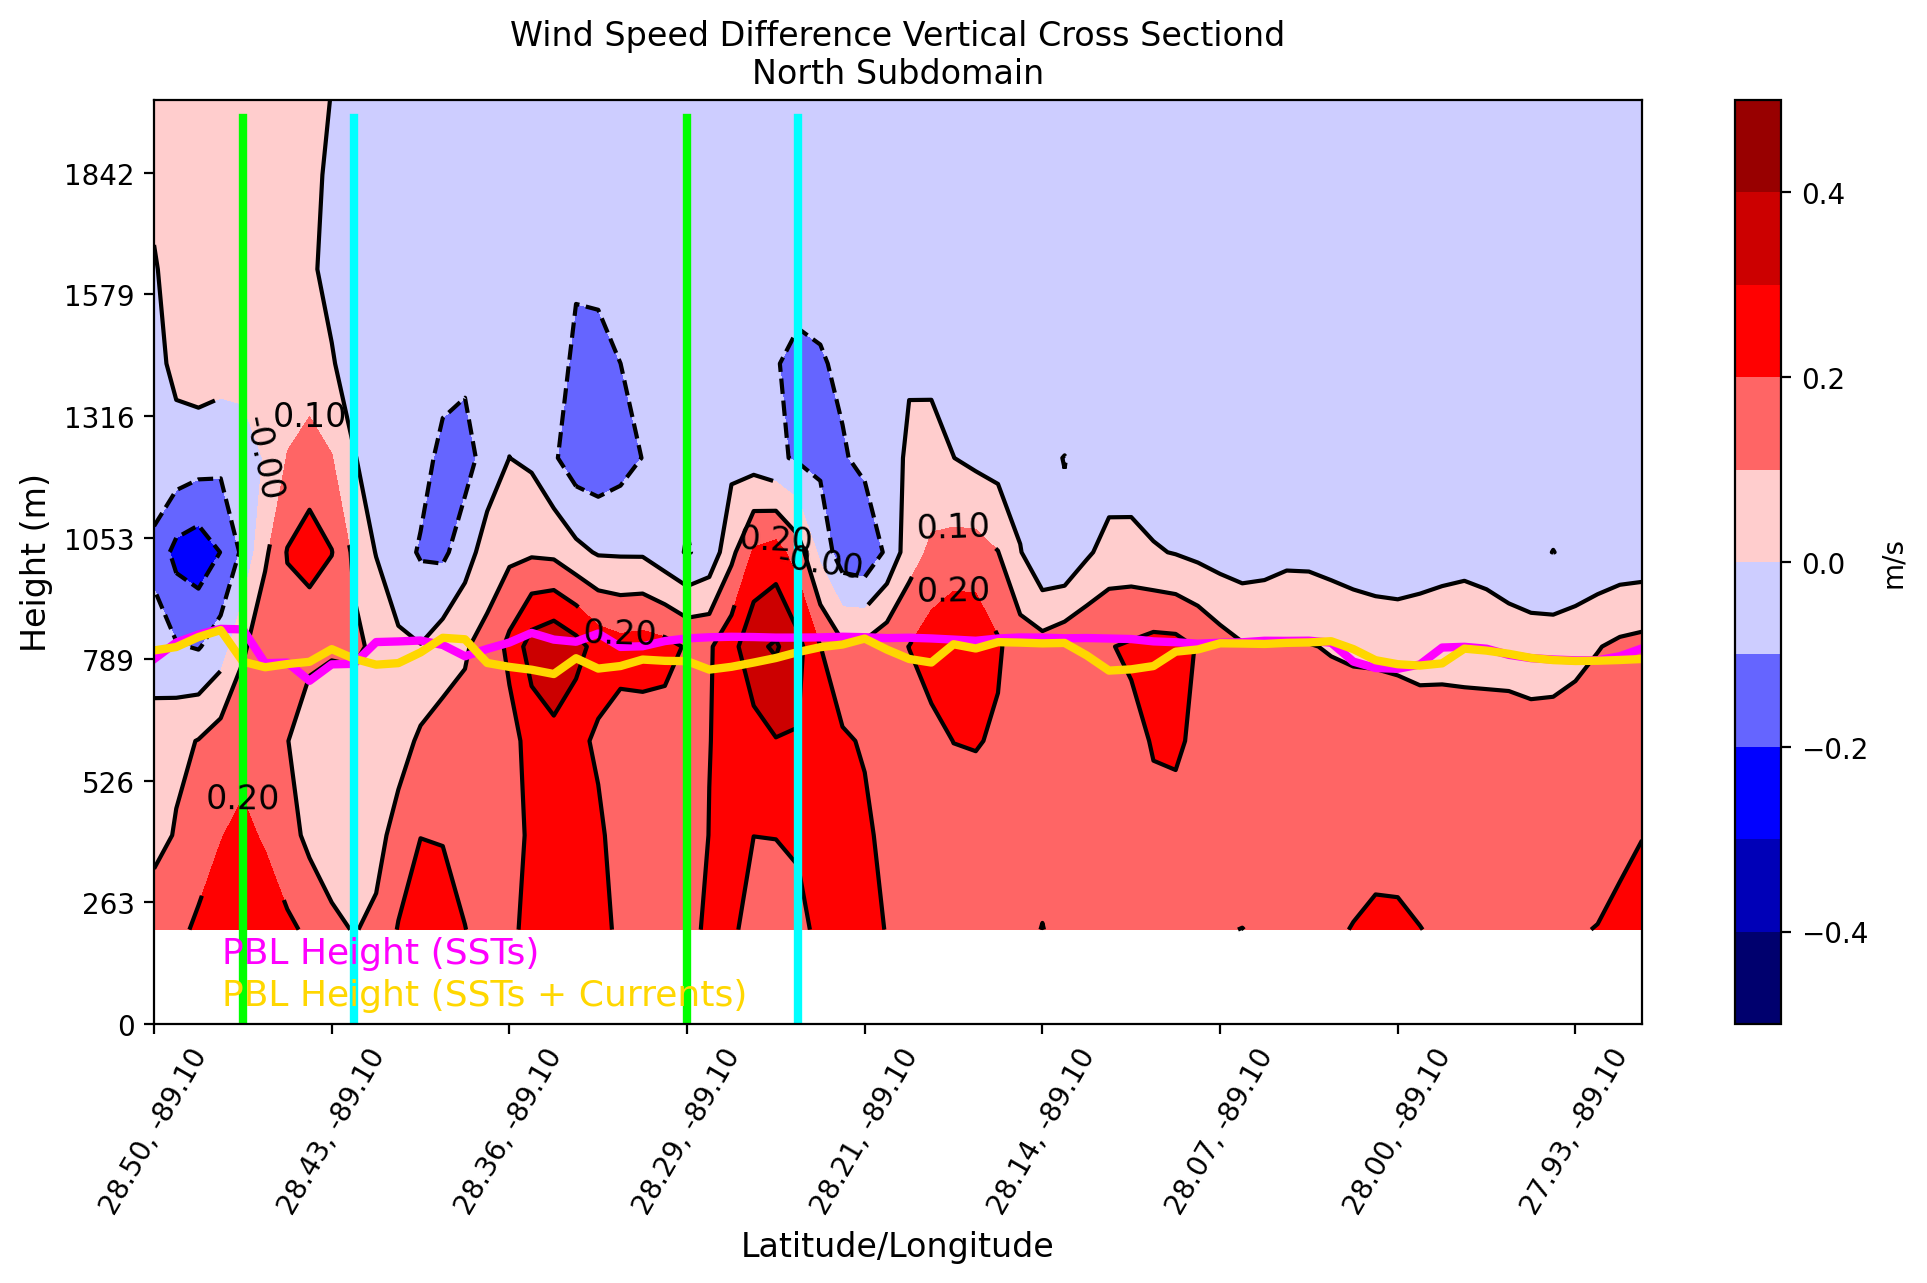

In [8]:
#CUR NORTH
z = z_cur_north
theta = N_speed_cur
pblh_line = N_pblh_line_cur

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

test_x = np.full((99), 9)
test_y = np.arange(0,1980,20)
test_x2 = np.full((99), 29)
test_y2 = np.arange(0,1980,20)
test_newX1 =np.full((99), 24)
test_newY1 = np.arange(0,1980,20)
test_newX2 = np.full((99), 4)
test_newY2 =np.arange(0,1980,20)

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5),cmap=get_cmap("Reds"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5), colors = 'black')

#cur_N_mean=np.mean(theta_cross)
#cur_N_std=np.std(theta_cross)
#print('cur_N_mean: ', cur_N_mean)
#print('cur_N_std: ', cur_N_std)

plt.clabel(theta_contours_line, inline=1, fontsize=13, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'gold',linewidth=3 )
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=13, color = 'gold')
plt.plot(test_x, test_y, color = 'cyan',linewidth=3)
plt.plot(test_x2, test_y2, color = 'cyan', linewidth=3)
plt.plot(test_newX1, test_newY1, color = 'lime', linewidth=3)
plt.plot(test_newX2, test_newY2, color = 'lime', linewidth=3)

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
#ax.set_xticks(x_ticks[::2])
#ax.set_xticklabels(x_labels[::2], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()





#SST NORTH----------------------------------------------------------------------------------
z = z_sst_north
theta = N_speed_sst
pblh_line = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5),cmap=get_cmap("Reds"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5), colors = 'black')

sst_N_mean=np.mean(theta_cross)
sst_N_std=np.std(theta_cross)
print('sst_N_mean: ', sst_N_mean)
print('sst_N_std: ', sst_N_std)

plt.clabel(theta_contours_line, inline=1, fontsize=13, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'magenta',linewidth=3)
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=12, color = 'magenta')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#CUR SOUTH--------------------------------------------------------------------------------------
z = z_cur_south
theta = S_speed_cur
pblh_line = S_pblh_line_cur

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line
test_xs = np.full((99), 39)
test_ys = np.arange(0,1980,20)
newX2 = np.full((99), 20)
newY2 =np.arange(0,1980,20)
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5),cmap=get_cmap("Reds"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5), colors = 'black')

cur_S_mean=np.mean(theta_cross)
cur_S_std=np.std(theta_cross)
print('cur_S_mean: ', cur_S_mean)
print('cur_S_std: ', cur_S_std)

plt.clabel(theta_contours_line, inline=1, fontsize=13, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'gold',linewidth=3 )
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=12, color = 'gold')
plt.plot(test_xs, test_ys, color = 'cyan' ,linewidth=3)
plt.plot(newX2, newY2, color = 'lime',linewidth=3)
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSouth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST South--------------------------------------------------------------------------
z = z_sst_south
theta = S_speed_sst
pblh_line = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5),cmap=get_cmap("Reds"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(4.0, 10.0, 0.5), colors = 'black')

sst_S_mean=np.mean(theta_cross)
sst_S_std=np.std(theta_cross)
print('sst_S_mean: ', sst_S_mean)
print('sst_S_std: ', sst_S_std)

plt.clabel(theta_contours_line, inline=1, fontsize=13, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'magenta',linewidth=3 )
ax.annotate('PBL Height',xy=(80, 105), xycoords='figure points', fontsize=12, color = 'magenta')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH DIFF--------------------------------------------------------------------------------------
z = z_sst_south
theta = S_diff 
pblh_line1 = S_pblh_line_cur
pblh_line2 = S_pblh_line_sst
start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line1
x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line2
test_xs = np.full((99), 39)
test_ys = np.arange(0,1980,20)
newX2 = np.full((99), 20)
newY2 =np.arange(0,1980,20)
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35, 0.4, 0.05),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.35, 0.4, 0.05), colors = 'black')
plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'magenta', linewidth=3 )
ax.annotate('PBL Height (SSTs)',xy=(80, 115), xycoords='figure points', fontsize=13, color = 'magenta')
plt.plot(x2, y2, color = 'gold',linewidth=3 )
ax.annotate('PBL Height (SSTs + Current)',xy=(80, 100), xycoords='figure points', fontsize=13, color = 'gold')
plt.plot(test_xs, test_ys, color = 'cyan',linewidth=3 )
plt.plot(newX2, newY2, color = 'lime',linewidth=3)
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Difference Vertical Cross Section\nSouth Subdomain")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH DIFF
z = z_sst_north
theta = N_diff 
pblh_line1 = N_pblh_line_cur
pblh_line2 = N_pblh_line_sst
start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.9, lon=-89.1)
theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)
fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
test_x = np.full((99), 9)
test_y = np.arange(0,1980,20)
test_x2 = np.full((99), 29)
test_y2 = np.arange(0,1980,20)
test_newX1 =np.full((99), 24)
test_newY1 = np.arange(0,1980,20)
test_newX2 = np.full((99), 4)
test_newY2 =np.arange(0,1980,20)
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line1
x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line2
theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.5, 0.6, 0.1),cmap=get_cmap("seismic"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.5, 0.6, 0.1), colors = 'black')
plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'magenta', linewidth=3)
ax.annotate('PBL Height (SSTs)',xy=(80, 115), xycoords='figure points', fontsize=13, color = 'magenta')
plt.plot(x2, y2, color = 'gold', linewidth=3)
ax.annotate('PBL Height (SSTs + Currents)',xy=(80, 100), xycoords='figure points', fontsize=13, color = 'gold')
plt.plot(test_x, test_y, color = 'cyan',linewidth=3)
plt.plot(test_x2, test_y2, color = 'cyan',linewidth=3)
plt.plot(test_newX1, test_newY1, color = 'lime', linewidth=3)
plt.plot(test_newX2, test_newY2, color = 'lime', linewidth=3)
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0,2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::8])
ax.set_xticklabels(x_labels[::8], rotation=60, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Difference Vertical Cross Sectiond\nNorth Subdomain")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


In [ ]:
cur_N_mean= 21.559647
cur_N_std= 10.91979885
sst_N_mean=21.5566
sst_N_std= 10.92403507
cur_S_mean=18.949574
cur_S_std= 11.31817722
sst_S_mean=  18.948545
sst_S_std= 11.31881714



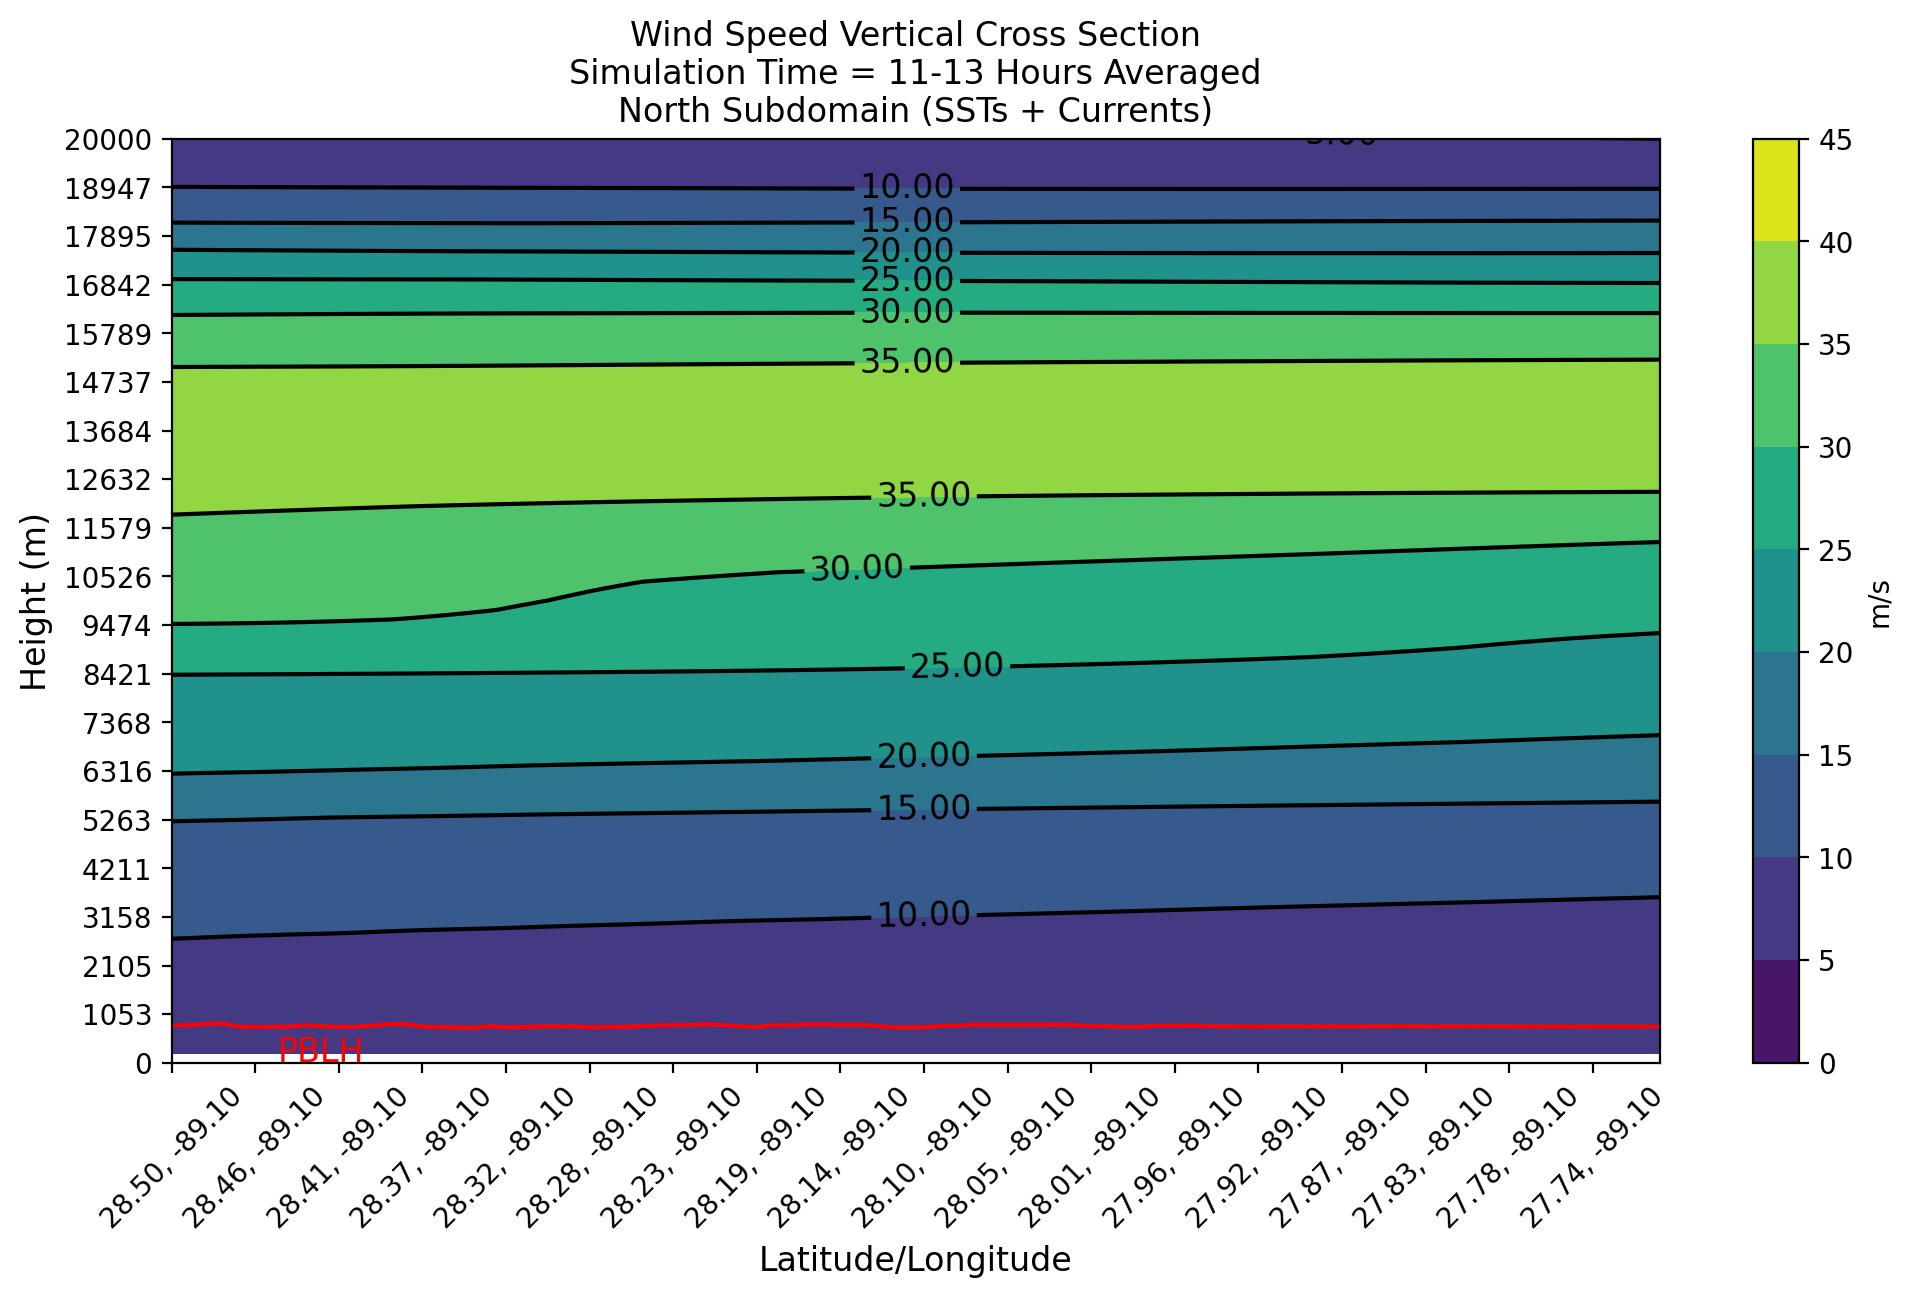

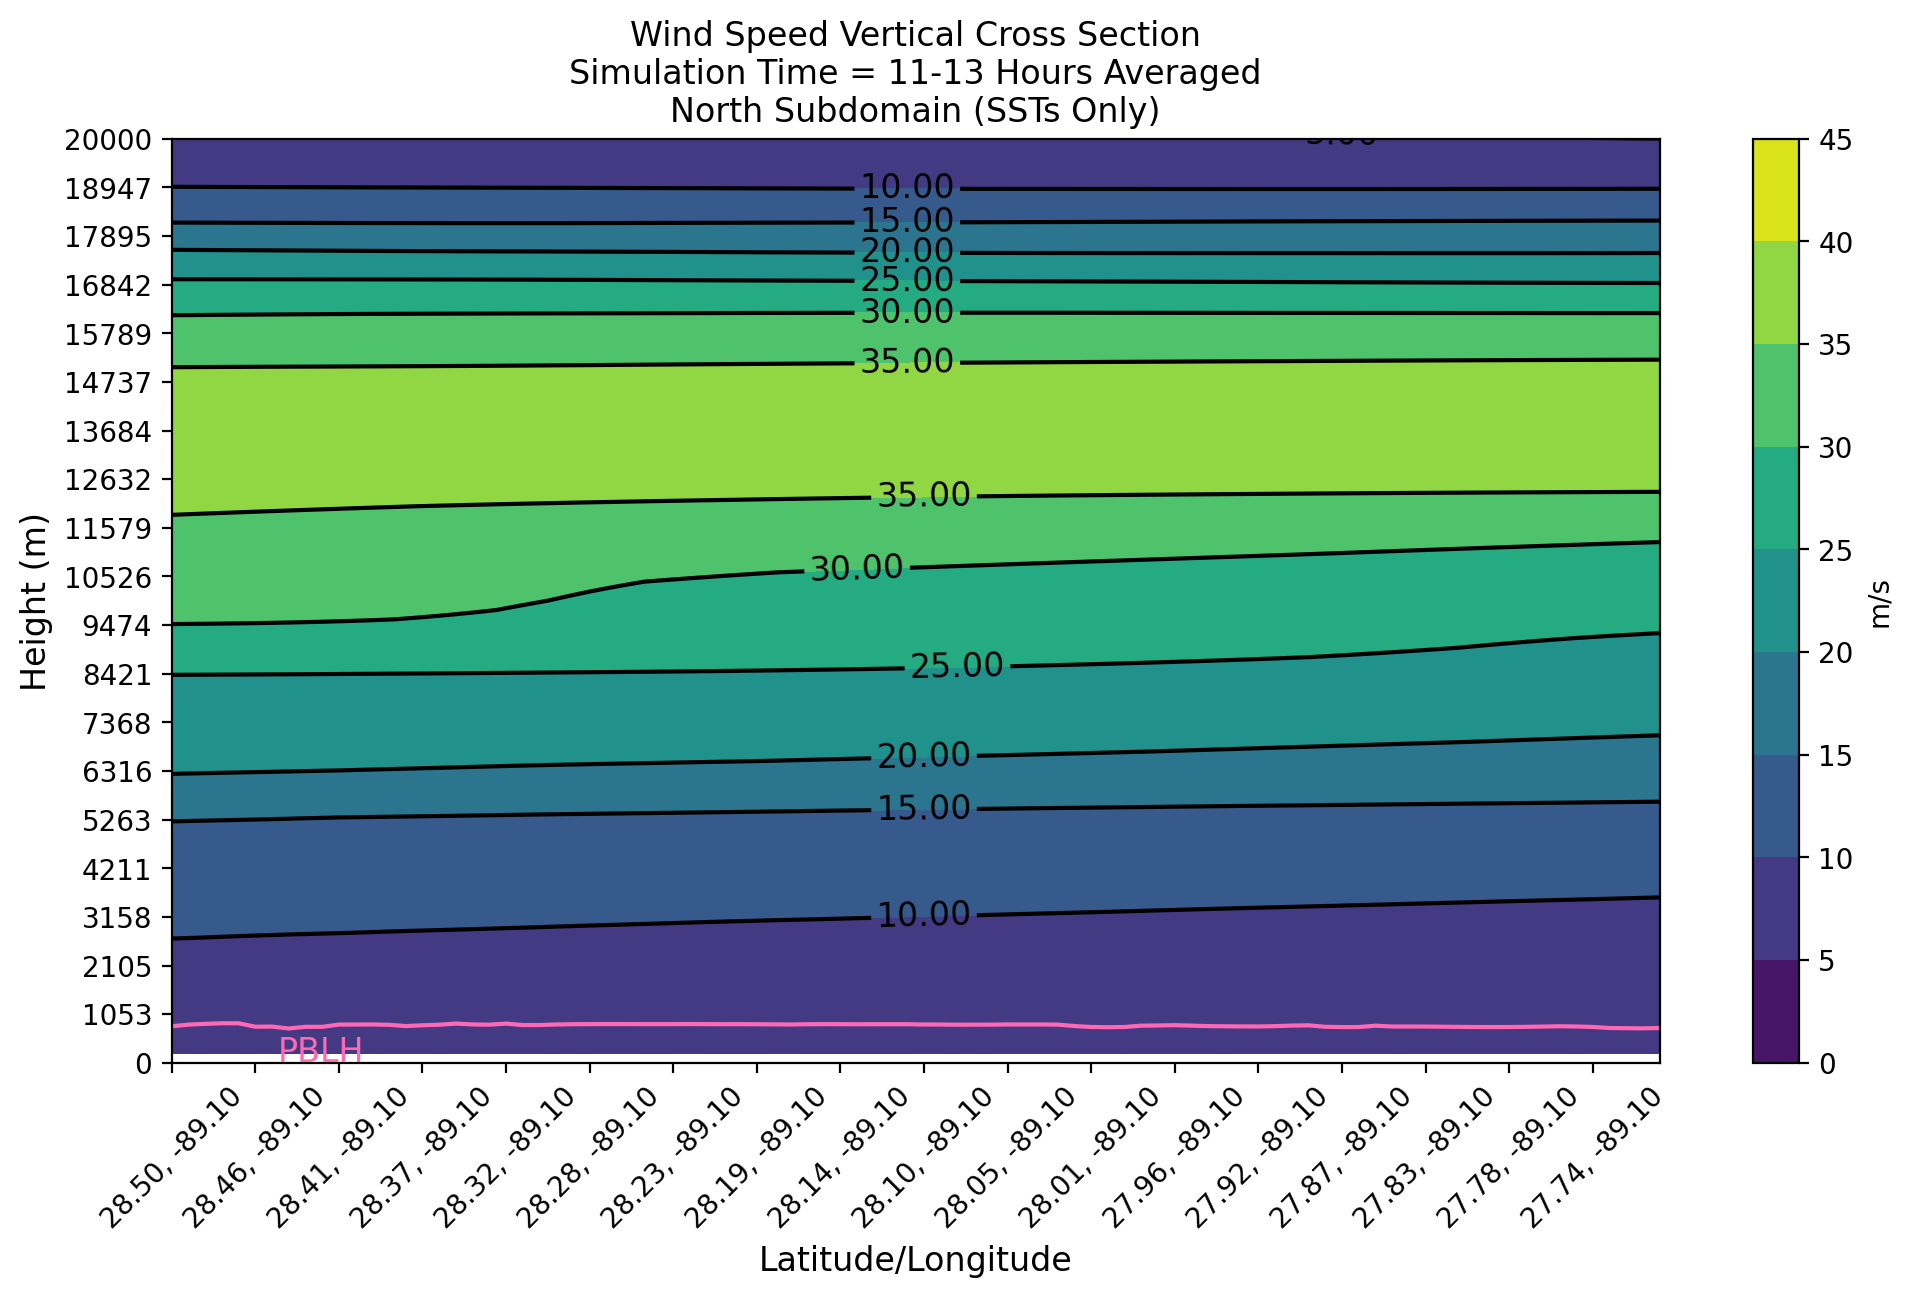

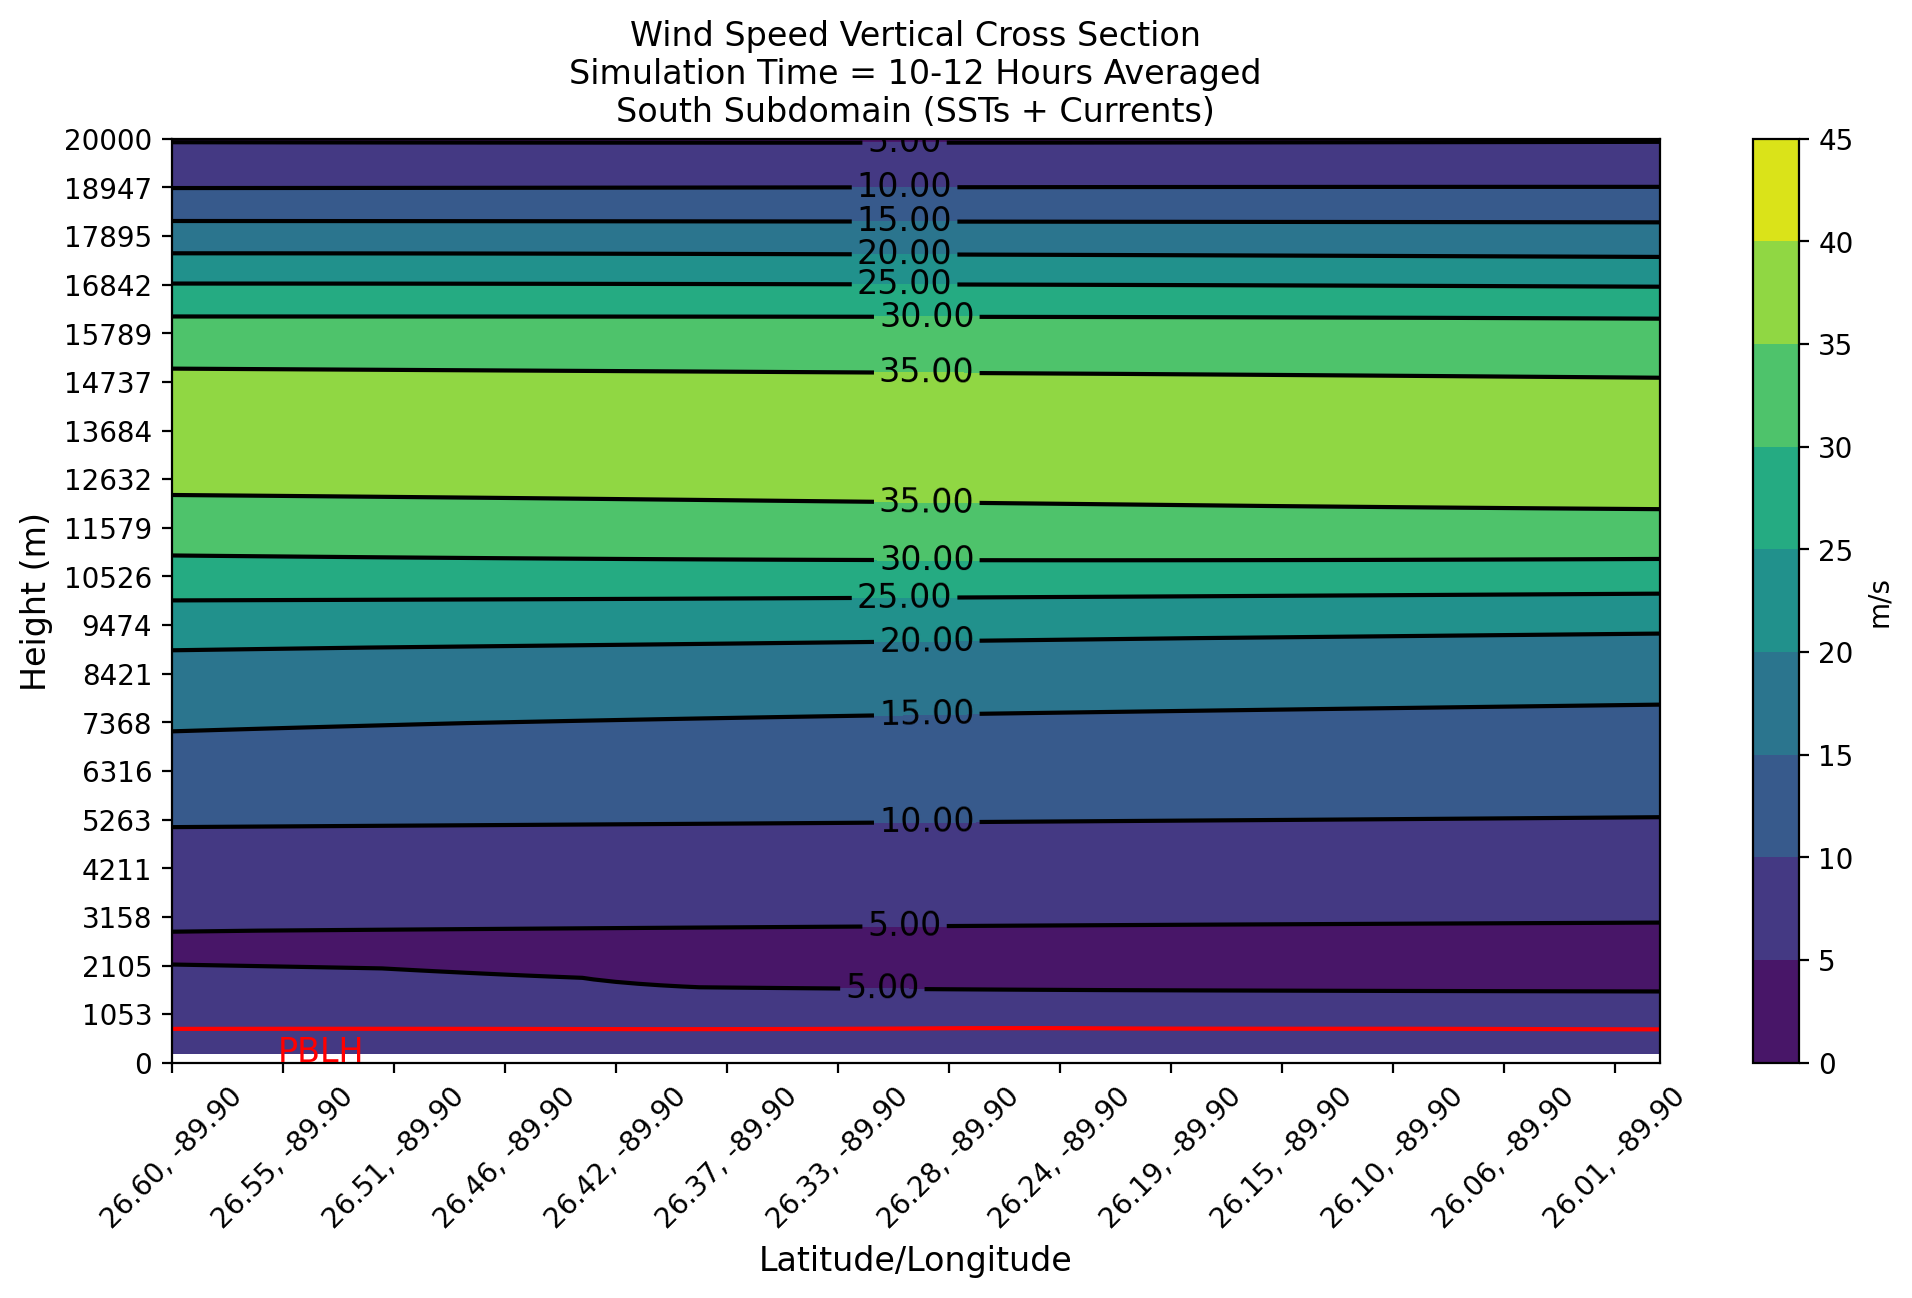

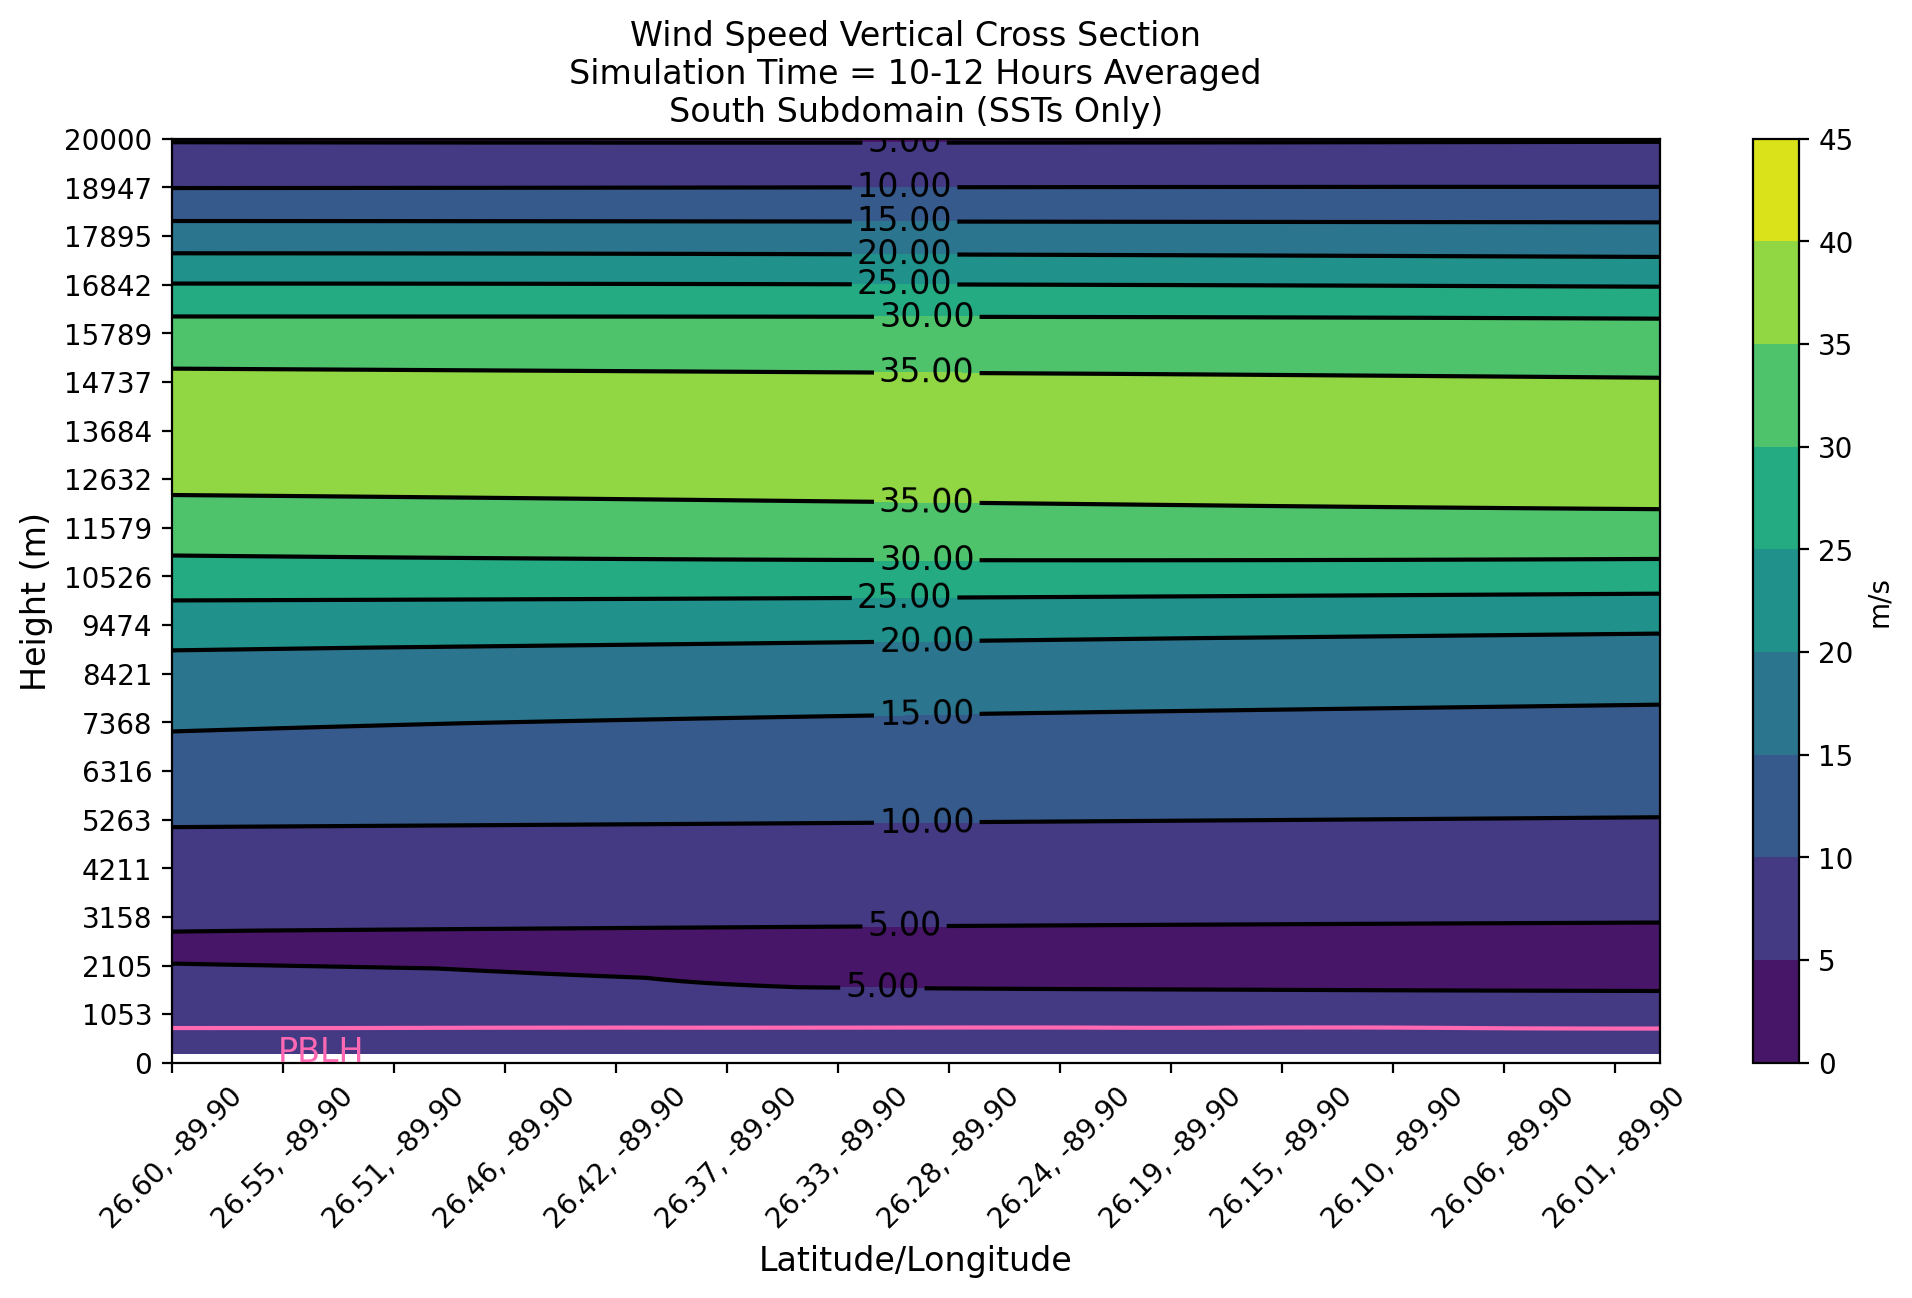

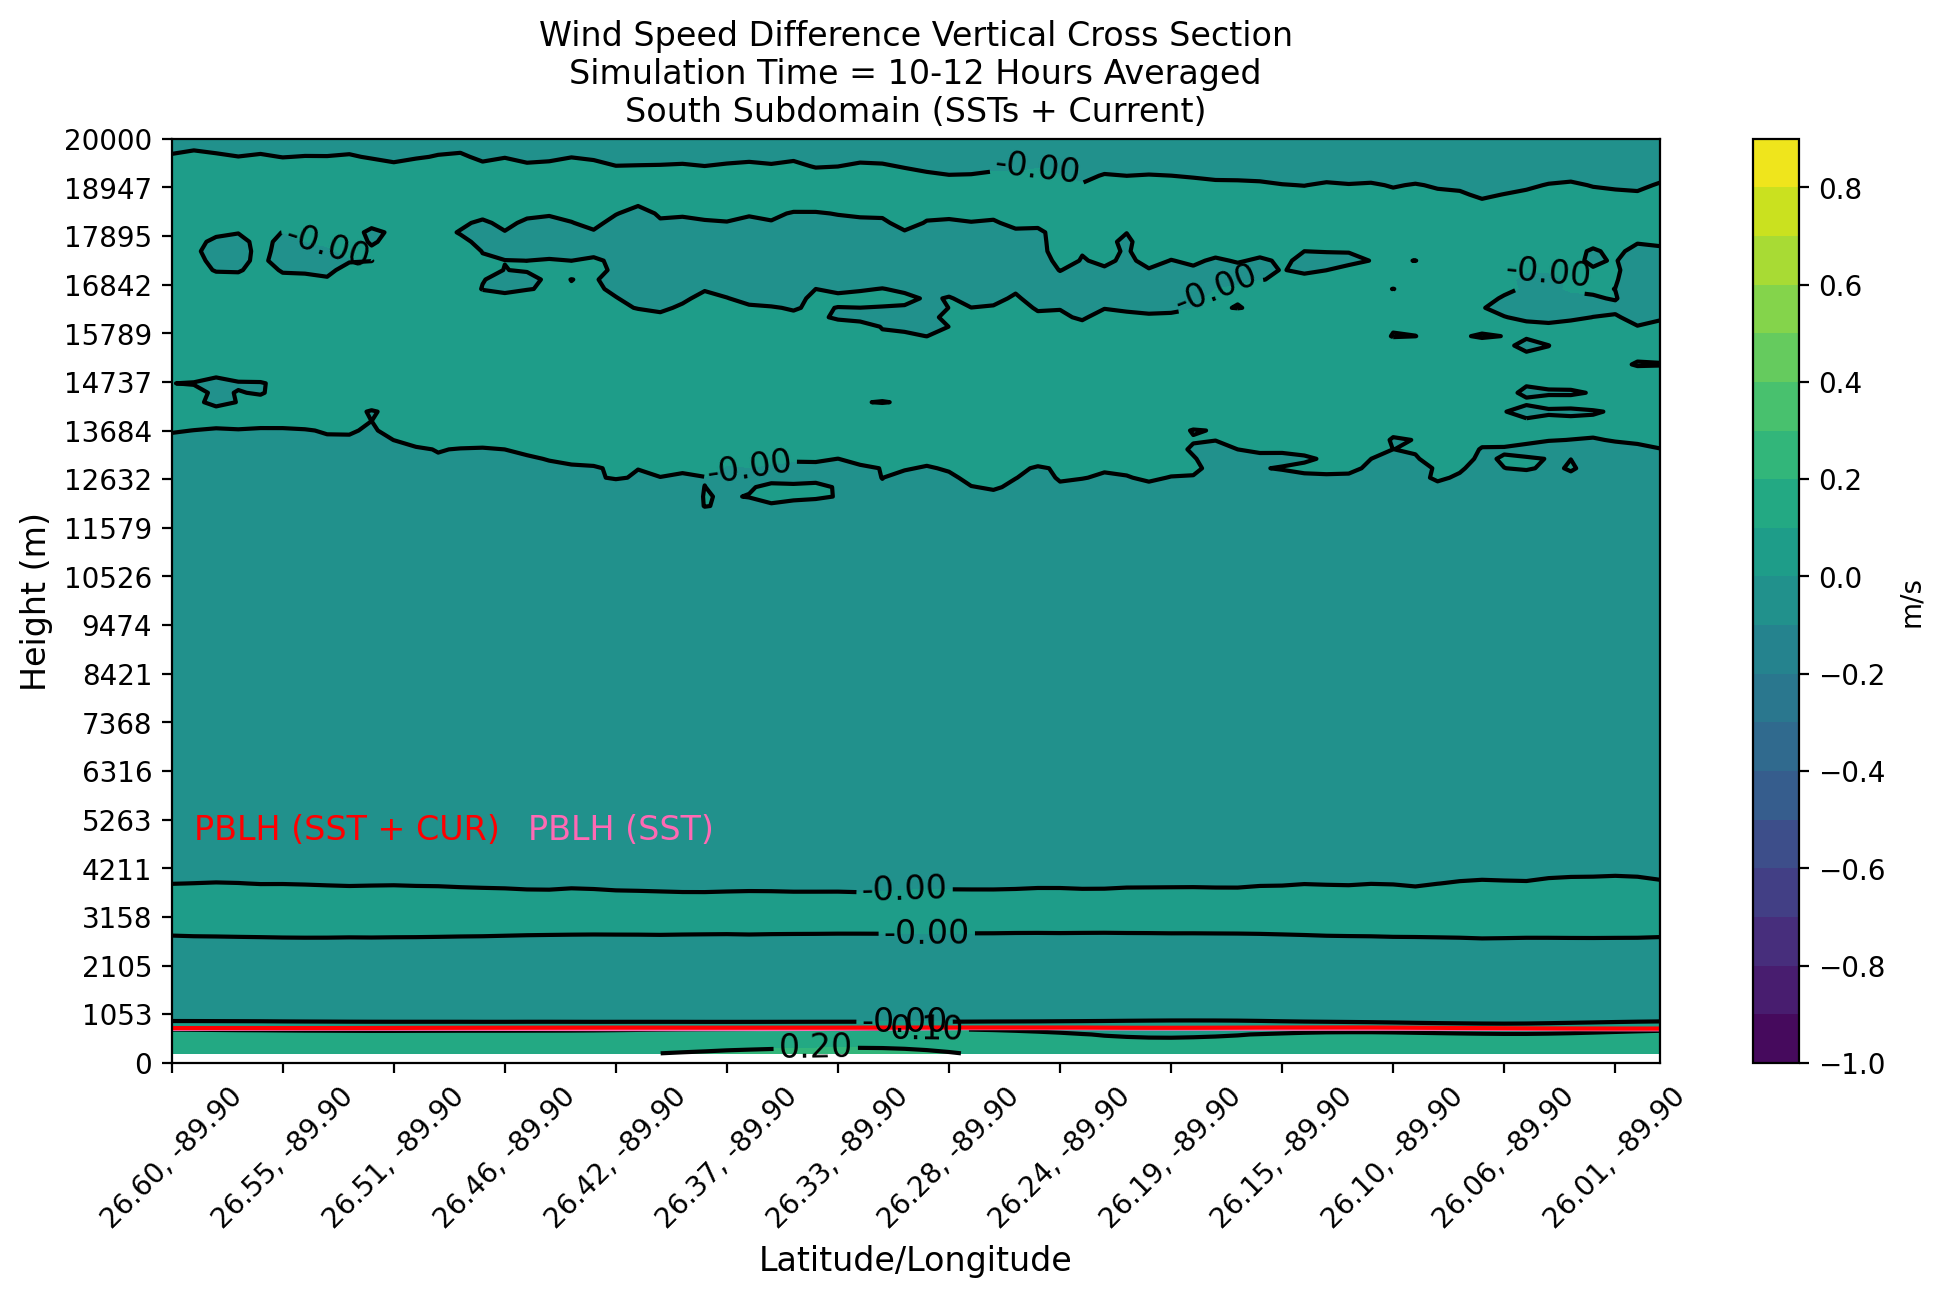

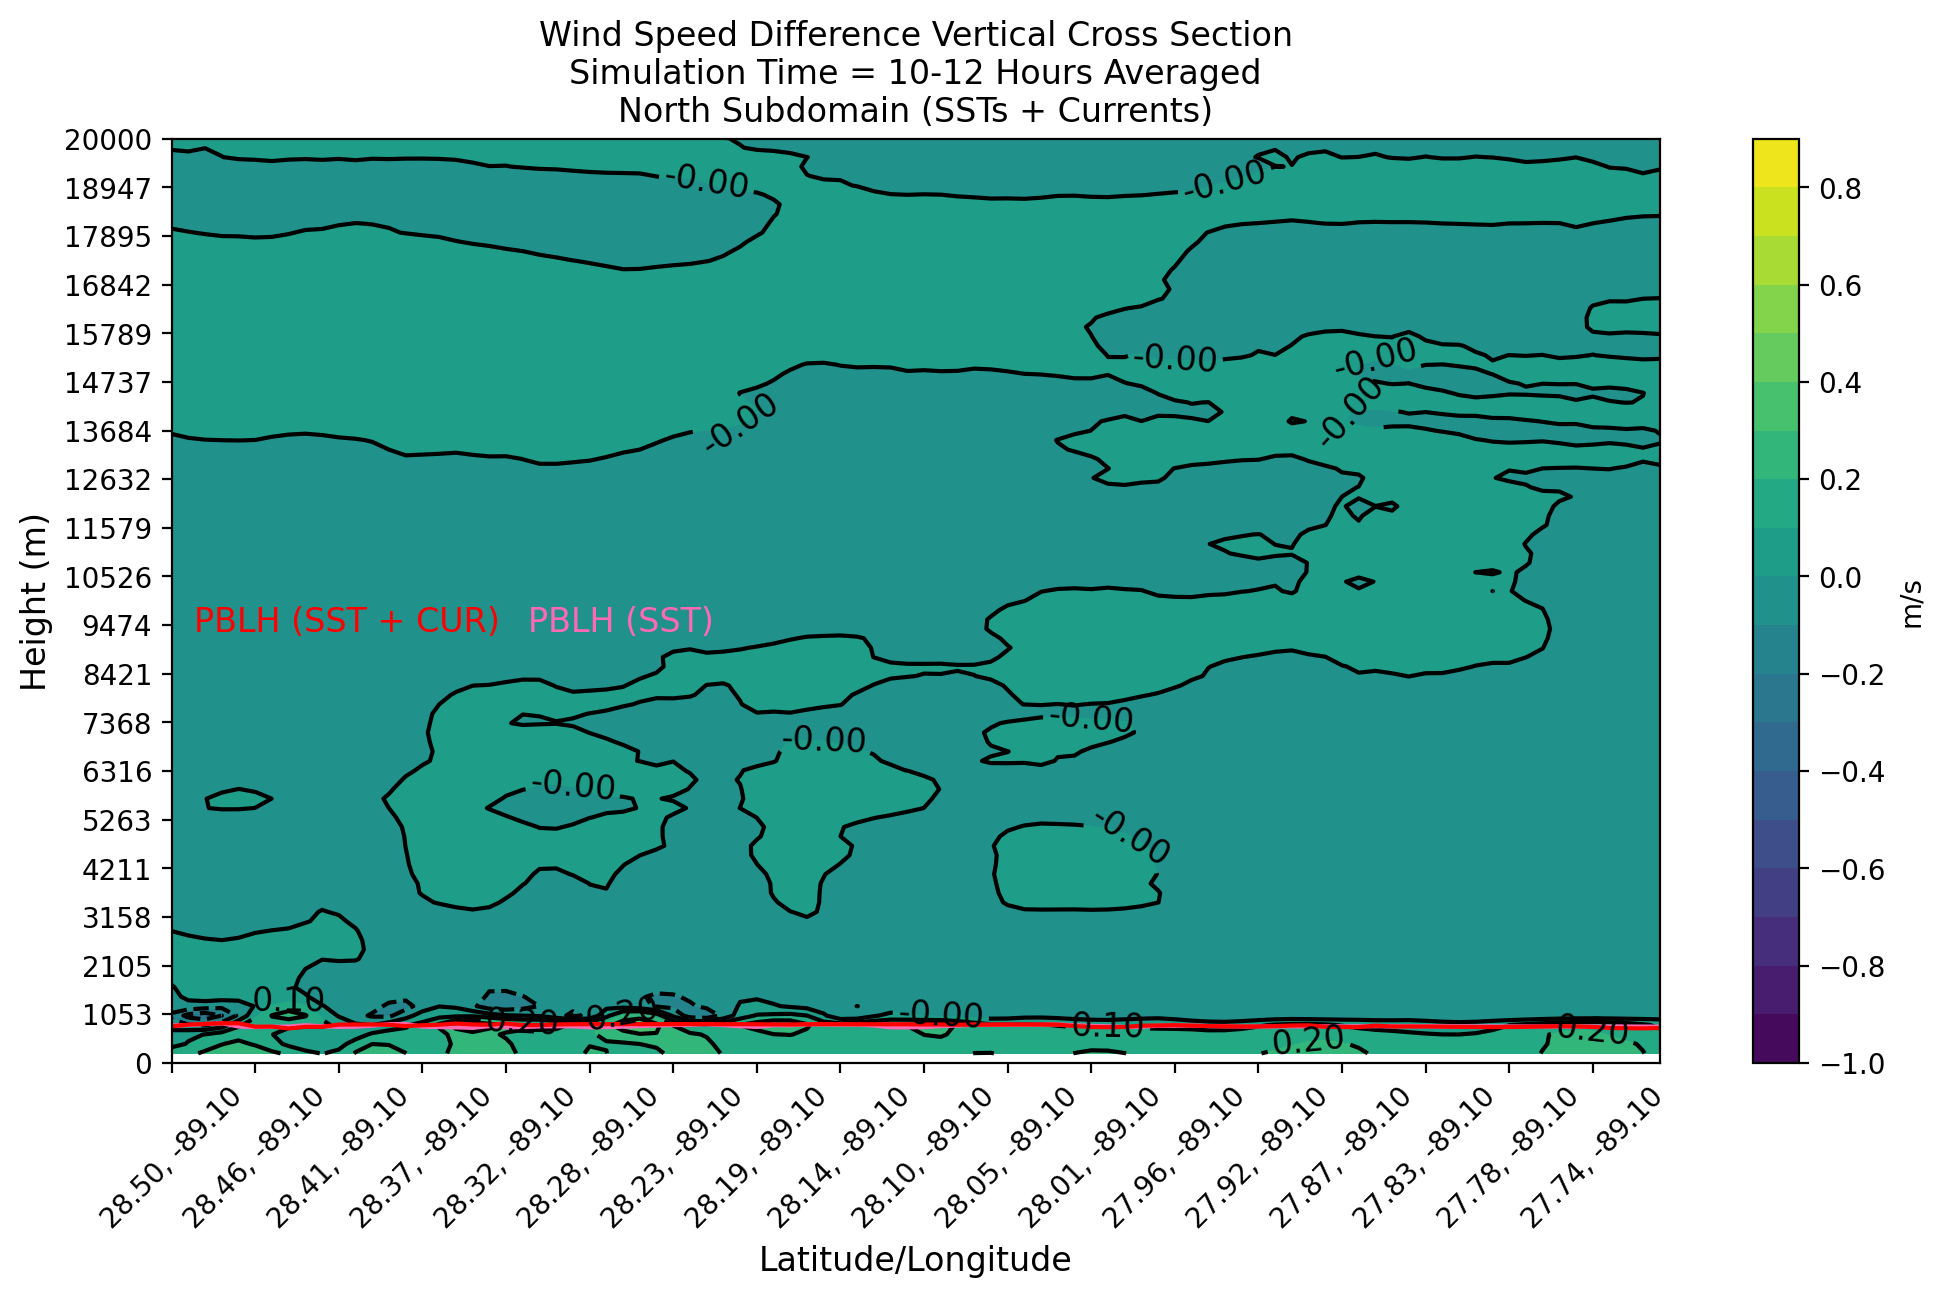

In [34]:
#Full Atmo to Show Jet

#CUR NORTH
z = z_cur_north
theta = N_speed_cur
pblh_line = N_pblh_line_cur

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0,  20000, 20))
ax.set_ylim(0, 20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsFullCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST NORTH
z = z_sst_north
theta = N_speed_sst
pblh_line = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0), colors = 'black')

plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0,  20000, 20))
ax.set_ylim(0, 20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsFullCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#CUR SOUTH
z = z_cur_south
theta = S_speed_cur
pblh_line = S_pblh_line_cur

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0,  20000, 20))
ax.set_ylim(0, 20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsFullCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST South
z = z_sst_south
theta = S_speed_sst
pblh_line = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(0, 50.0, 5.0), colors = 'black')

plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0,  20000, 20))
ax.set_ylim(0, 20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsFullCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH DIFF
z = z_sst_south
theta = S_diff 
pblh_line1 = S_pblh_line_cur
pblh_line2 = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-1.0, 1.0, 0.1),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-1.0, 1.0, 0.1), colors = 'black')

plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(190, 165), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(70, 165), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0,  20000, 20))
ax.set_ylim(0, 20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Difference Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs + Current)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'south_windsFullCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH DIFF
z = z_sst_north
theta = N_diff 
pblh_line1 = N_pblh_line_cur
pblh_line2 = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-1.0, 1.0, 0.1),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'm/s')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-1.0, 1.0, 0.1), colors = 'black')

plt.clabel(theta_contours_line, fontsize=12, fmt='%1.2f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(190, 240), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(70, 240), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 20000, 20))
ax.set_ylim(0,20000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Wind Speed Difference Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Winds/'
plt.savefig(save_results_to + 'north_windsFullCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

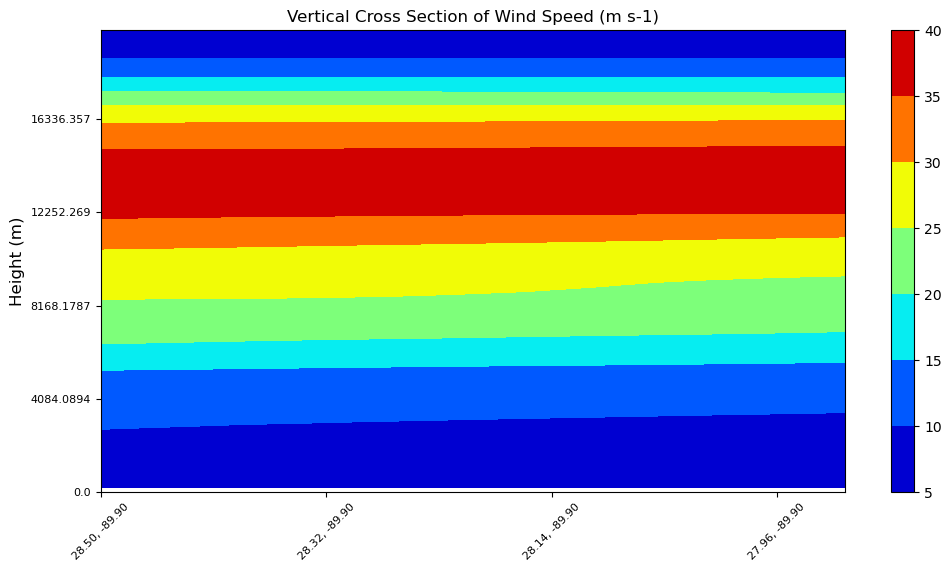

In [6]:
z = getvar(cur_wrfout12, "z")
wspd =  getvar(cur_wrfout12, "uvmet_wspd_wdir", units='m s-1')[0,:]

start_point = CoordPair(lat=28.5, lon=-89.9)
end_point = CoordPair(lat=27.9, lon=-89.9)

wspd_cross = vertcross(wspd, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6))
ax = plt.axes()

wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))

plt.colorbar(wspd_contours, ax=ax)

coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::20])
ax.set_yticklabels(vert_vals[::20], fontsize=8)

ax.set_ylabel("Height (m)", fontsize=12)

plt.title("Vertical Cross Section of Wind Speed (m s-1)")

plt.show()

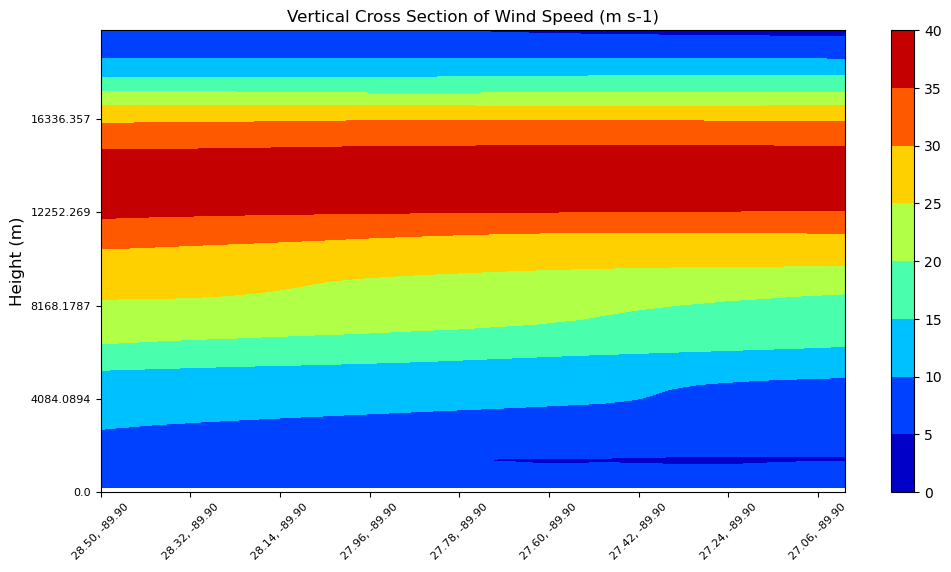

In [7]:
#cross section is further south

z = getvar(cur_wrfout12, "z")
wspd =  getvar(cur_wrfout12, "uvmet_wspd_wdir", units='m s-1')[0,:]

start_point = CoordPair(lat=28.5, lon=-89.9)
end_point = CoordPair(lat=27.0, lon=-89.9)

wspd_cross = vertcross(wspd, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6))
ax = plt.axes()

wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))

plt.colorbar(wspd_contours, ax=ax)

coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)

vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::20])
ax.set_yticklabels(vert_vals[::20], fontsize=8)

ax.set_ylabel("Height (m)", fontsize=12)

plt.title("Vertical Cross Section of Wind Speed (m s-1)")

plt.show()